In [98]:
import numpy as np
import pandas as pd
# from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, accuracy_score, RocCurveDisplay, make_scorer, f1_score, precision_score, recall_score
from sklearn.feature_selection import chi2, VarianceThreshold, SelectKBest, mutual_info_classif, f_classif, RFE
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, Normalizer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

from imblearn import FunctionSampler
from imblearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from scipy.stats import chi2_contingency

from src.data_processing import football_utils
from src.data_processing import football_repoistory
from src.data_processing import goals_preprocess_feature
from src.data_processing import lm_winner_preprocess_feature
from src.data_processing import points_preprocess_feature
from src.data_processing import possession_preprocess_feature
from src.data_processing import streaks_preprocess_feature
from src.data_processing import bets_preprocess_feature
from src.data_processing import football_preprocess_features

import category_encoders as ce

from collections import Counter

sns.set_context('paper')
sns.set_style('darkgrid')

# to reload modules
# %load_ext autoreload
# %autoreload 2
# from src.data_processing import points_preprocess_feature

import logging

SEARCH_PARAMS=True
VERBOSE=False

In [3]:
logger = logging.getLogger(__name__)

In [4]:
def prepare_target(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc


In [5]:
# Load data from db to file
football_repoistory.load_and_chunk_data()

In [6]:
df_detailed_matches = pd.read_csv(r'C:\Users\kamil\Documents\eu_soccer_ml\chunk_data\chunk_1.csv')

In [7]:
# profile = ProfileReport(df_detailed_matches, title='Detailed matches', minimal=True)
# profile.to_file(output_file="report/first_profile.html")

In [8]:
df_detailed_matches['date'] = pd.to_datetime(df_detailed_matches['date']).dt.date
df_detailed_matches[['country_name', 'league_name', 'season', 'home_team', 'away_team', 'result_match', 'possession']] = df_detailed_matches[
    ['country_name', 'league_name', 'season', 'home_team', 'away_team', 'result_match', 'possession']].astype(
    'category')

df_detailed_matches = df_detailed_matches.drop(['PSH', 'PSD', 'PSA'], axis=1)

In [9]:
# Retrieve all teams
teams = pd.unique(df_detailed_matches[['home_team', 'away_team']].values.ravel('K'))

In [10]:
# Count how many goals team get in last match
df_detailed_matches = goals_preprocess_feature.count_last_match_goals(df_detailed_matches, teams)
df_detailed_matches = football_utils.fill_nan_goals(df_detailed_matches, 'lm_goals_home', 'lm_goals_away')


In [11]:
# Count average goals team get in last n matches
df_detailed_matches = goals_preprocess_feature.count_average_goals_from_last_n_matches(df_detailed_matches, teams)
df_detailed_matches = football_utils.fill_nan_goals(df_detailed_matches, 'avg_l5m_h', 'avg_l5m_hh')
df_detailed_matches = football_utils.fill_nan_goals(df_detailed_matches, 'avg_l5m_a', 'avg_l5m_aa')

In [12]:
# Count streak wins or lose in last matches
df_detailed_matches = streaks_preprocess_feature.count_streak_wins(df_detailed_matches, teams)
df_detailed_matches = streaks_preprocess_feature.count_streak_lose(df_detailed_matches, teams)

In [13]:
# Process xml column, get team possession in last match
df_detailed_matches = possession_preprocess_feature.xml_to_feature_possession(df_detailed_matches)
df_detailed_matches_nan_possession = df_detailed_matches.loc[
    (df_detailed_matches['awaypos'].isna()) | (df_detailed_matches['homepos'].isna())]
df_detailed_matches = possession_preprocess_feature.fill_nan_possession(df_detailed_matches,
                                                                        df_detailed_matches_nan_possession)
df_detailed_matches = possession_preprocess_feature.get_last_match_possession(df_detailed_matches, teams)
df_detailed_matches = df_detailed_matches.drop(['homepos', 'awaypos'], axis=1)

In [14]:
# Count days since last match
df_detailed_matches = football_preprocess_features.count_days_since_last_match(df_detailed_matches, teams)

In [15]:
# Get last match winner between teams
df_detailed_matches = lm_winner_preprocess_feature.get_last_match_winner(df_detailed_matches)
df_detailed_matches = lm_winner_preprocess_feature.fill_nan_last_match_winner(df_detailed_matches)

In [16]:
# Count team points
df_detailed_matches = points_preprocess_feature.count_points(df_detailed_matches, teams)

In [17]:
# Count team average points from n last matches
df_detailed_matches = points_preprocess_feature.count_average_points_from_n_last_matches(df_detailed_matches, teams)
df_avg_goals_nan = df_detailed_matches.loc[
    (df_detailed_matches['avg_points_l5m_h'].isna()) | (df_detailed_matches['avg_points_l5m_a'].isna())]
df_detailed_matches = points_preprocess_feature.fill_nan_average_points(df_detailed_matches, df_avg_goals_nan)

In [18]:
df_detailed_matches = bets_preprocess_feature.fill_nan_bets(df_detailed_matches)

In [19]:
X = df_detailed_matches.drop(axis=1, columns=['home_team_goal', 'away_team_goal', 'possession', 'result_match', ])
y = df_detailed_matches['result_match']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333, stratify=y)
train_match_api_id = X_train.pop('match_api_id')
test_match_api_id = X_test.pop('match_api_id')

y_train, y_test = prepare_target(y_train, y_test)

print(f'X train shape: {X_train.shape}')
print(f'y train shape: {y_train.shape}')
print(f'X test shape: {X_test.shape}')
print(f'y test shape: {y_test.shape}')

X train shape: (3995, 38)
y train shape: (3995,)
X test shape: (999, 38)
y test shape: (999,)


In [21]:
print(f'y train value counts: \n{Counter(y_train)}')
print(f'y test value counts: \n{Counter(y_test)}')

y train value counts: 
Counter({2: 1912, 0: 1070, 1: 1013})
y test value counts: 
Counter({2: 478, 0: 268, 1: 253})


In [22]:
# profile = ProfileReport(pd.concat([X,y], axis=1), title='Detailed matches', dark_mode=True, minimal=True)
# profile.config.interactions.targets = []
# profile.to_file(output_file="report/second_profile.html")

In [23]:
X_train_num = X_train.select_dtypes(include='number')
X_test_num = X_test.select_dtypes(include='number')

In [24]:
X_train_num.X_cat_train().round(2)

,stage,B365H,B365D,B365A,BWH,BWD,BWA,LBH,LBD,LBA,...,streak_lh,streak_la,last_match_possession_away,last_match_possession_home,days_since_lma,days_since_lmh,points_home,points_away,avg_points_l5m_h,avg_points_l5m_a
count,3995.00,3995.00,3995.00,3995.00,3995.00,3995.00,3995.00,3995.00,3995.00,3995.00,...,3995.00,3995.00,3995.00,3995.00,3995.00,3995.00,3995.0,3995.00,3995.00,3995.00
mean,18.29,2.56,3.72,4.66,2.49,3.65,4.34,2.44,3.59,4.30,...,1.91,1.62,49.81,48.16,10.27,9.78,22.1,22.46,1.32,1.38
std,10.90,1.66,0.94,3.55,1.51,0.92,2.95,1.46,0.84,2.97,...,2.35,2.33,7.84,7.72,24.77,16.10,15.6,15.75,0.41,0.46
min,1.00,1.04,1.40,1.10,1.03,1.65,1.10,1.04,1.40,1.10,...,0.00,0.00,21.00,4.00,2.00,2.00,0.0,0.00,0.40,0.40
25%,9.00,1.67,3.25,2.62,1.65,3.20,2.55,1.67,3.20,2.50,...,0.00,0.00,45.00,43.00,6.00,6.00,9.0,9.00,1.00,1.00
50%,18.00,2.10,3.40,3.60,2.10,3.35,3.45,2.10,3.30,3.30,...,1.00,1.00,49.00,48.00,7.00,7.00,20.0,21.00,1.29,1.40
75%,28.00,2.75,3.75,5.50,2.65,3.70,5.10,2.60,3.60,5.00,...,3.00,2.00,55.00,53.00,8.00,8.00,34.0,34.00,1.80,1.80
max,38.00,23.00,13.00,34.00,21.00,15.00,31.00,17.00,12.00,26.00,...,20.00,19.00,80.00,96.00,818.00,455.00,71.0,72.00,2.60,2.60


In [25]:
print(f'Shape X_train: {X_train_num.shape}')
print(f'Shape X_test: {X_test_num.shape}')

Shape X_train: (3995, 31)
Shape X_test: (999, 31)


In [26]:
def remove_outlier_IQR(X, y, low_p=01., high_p=90.):
    features = X.select_dtypes(include='number').columns
    df = X.copy()
    df['target'] = y

    indices = [x for x in df.index]
    out_indexlist = []

    for col in features:
        Q1 = np.percentile(df[col], low_p)
        Q3 = np.percentile(df[col], high_p)

        cut_off = (Q3 - Q1) * 1.5
        upper, lower = Q3 + cut_off, Q1 - cut_off

        outliers_index = df[col][(df[col] < lower) | (df[col] > upper)].index.tolist()
        out_indexlist.extend(outliers_index)

    out_indexlist = list(set(out_indexlist))

    clean_data = np.setdiff1d(indices, out_indexlist)

    y_ = df['target'].loc[clean_data]
    X_ = X.loc[clean_data]

    if VERBOSE:
        print(f'X shape: {X_.shape}, y shape: {y_.shape}')
    return X_, y_

In [27]:
X_train_out, y_train_out = remove_outlier_IQR(X_train_num, y_train)
X_test_out, y_test_out = remove_outlier_IQR(X_test_num, y_test)
print(f'Shape X_train: {X_train_out.select_dtypes(include="number").shape}')
print(f'Shape X_test: {y_train_out.shape}')

print(f'Shape X_train: {X_test_out.select_dtypes(include="number").shape}')
print(f'Shape X_test: {y_test_out.shape}')

Shape X_train: (3637, 31)
Shape X_test: (3637,)
Shape X_train: (916, 31)
Shape X_test: (916,)


>Threshold=0.00, Features=31
>Threshold=0.05, Features=31
>Threshold=0.10, Features=31
>Threshold=0.15, Features=31
>Threshold=0.20, Features=30
>Threshold=0.25, Features=29
>Threshold=0.30, Features=27
>Threshold=0.35, Features=26
>Threshold=0.40, Features=22
>Threshold=0.45, Features=22
>Threshold=0.50, Features=21


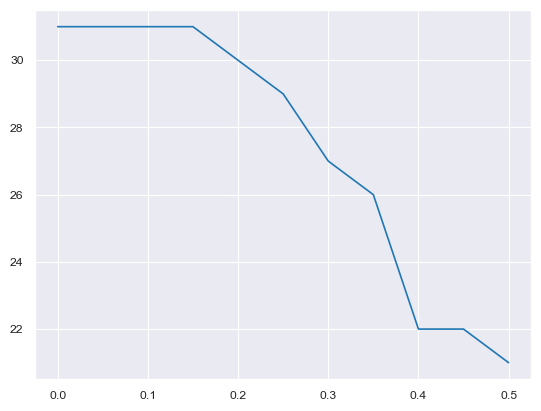

In [28]:
# Remove low variance features
thresholds = np.arange(0.0, 0.55, 0.05)
results = list()

for t in thresholds:
    v_threshold = VarianceThreshold(threshold=t)
    X_sel = v_threshold.fit_transform(X_train_out.select_dtypes(include='number'))
    n_features = X_sel.shape[1]
    print('>Threshold=%.2f, Features=%d' % (t, n_features))
    results.append(n_features)

plt.plot(thresholds, results)
plt.show()

In [29]:
v_threshold = VarianceThreshold(threshold=0.2)
v_threshold.fit(X_train_out)
supported_cols = v_threshold.get_support(indices=True)

X_train_vs_ = v_threshold.transform(X_train_out)
X_test_vs_ = v_threshold.transform(X_test_out)

In [30]:
X_train_vs = pd.DataFrame(data=X_train_vs_, columns=X_train_out.iloc[:, supported_cols].columns)
X_test_vs = pd.DataFrame(data=X_test_vs_, columns=X_test_out.iloc[:, supported_cols].columns)

print(X_train_vs.shape)
print(X_test_vs.shape)

(3637, 30)
(916, 30)


In [31]:
from IPython.core.display_functions import display

X_num_train_scal = pd.DataFrame(data=MinMaxScaler().fit_transform(X_train_vs.select_dtypes(include='number')),
                                columns=X_train_vs.select_dtypes(include='number').columns)
X_num_test_scal = pd.DataFrame(data=MinMaxScaler().fit_transform(X_test_vs.select_dtypes(include='number')),
                               columns=X_test_vs.select_dtypes(include='number').columns)

print('X train enc \n:')
display(X_num_train_scal.head(1))
print('X test enc shape: \n')
display(X_num_test_scal.head(1))

X train enc 
:


,stage,B365H,B365D,B365A,BWH,BWD,BWA,LBH,LBD,LBA,...,streak_wa,streak_lh,streak_la,last_match_possession_away,last_match_possession_home,days_since_lma,days_since_lmh,points_home,points_away,avg_points_l5m_a
0,0.0,0.062682,0.393443,0.263039,0.058394,0.383178,0.297794,0.061321,0.411765,0.303519,...,0.0,0.0,0.0,0.508475,0.608696,0.296296,0.285714,0.0,0.0,0.444179


X test enc shape: 



,stage,B365H,B365D,B365A,BWH,BWD,BWA,LBH,LBD,LBA,...,streak_wa,streak_lh,streak_la,last_match_possession_away,last_match_possession_home,days_since_lma,days_since_lmh,points_home,points_away,avg_points_l5m_a
0,0.0,0.0,1.0,0.77221,0.011024,0.705882,0.550706,0.005146,0.673913,0.706745,...,0.0,0.0,0.0,0.464286,0.607143,0.259259,0.269231,0.0,0.0,0.351097


In [32]:
# y_train_enc, y_test_enc = prepare_target(y_train.iloc[X_num_train_scal.index], y_test.iloc[X_num_test_scal.index])

print(f'y train enc shape: {y_train_out.shape}')
print(f'y test enc shape: {y_test_out.shape}')

y train enc shape: (3637,)
y test enc shape: (916,)


In [33]:
smote = SMOTE()
X_resample, y_resample = smote.fit_resample(X_num_train_scal, y_train_out)

print('X_resample shape: %s, y_resample: %s' % (X_resample.shape, y_resample.shape))

unique, counts = np.unique(y_resample, return_counts=True)
print('Count values: \n %s' % np.asarray((unique, counts)).T)

X_resample shape: (5205, 30), y_resample: (5205,)
Count values: 
 [[   0 1735]
 [   1 1735]
 [   2 1735]]


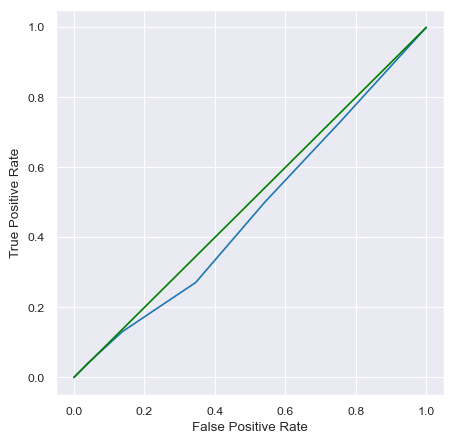

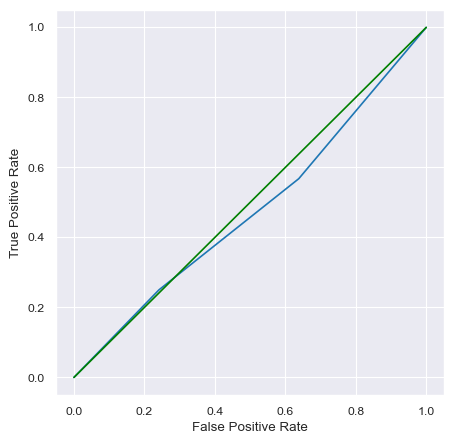

In [34]:
model = KNeighborsClassifier()
model.fit(X_resample, y_resample)
y_proba = model.predict_proba(X_num_test_scal)
y_pred = model.predict(X_num_test_scal)

def plot_sklearn_roc_curve(y_real, y_pred):
    fpr, tpr, _ = roc_curve(y_real, y_pred, pos_label=1)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5, 5)
    plt.plot([0, 1], [0, 1], color='g')

# Plots the ROC curve using the sklearn methods - Good plot
plot_sklearn_roc_curve(y_test_out, y_proba[:, 1])
# Plots the ROC curve using the sklearn methods - Bad plot
plot_sklearn_roc_curve(y_test_out, y_pred)

In [35]:
score = accuracy_score(y_test_out, y_pred)
print(f'score: {score}')

score: 0.32751091703056767


In [95]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=43)
# recall_score = make_scorer(recall_score, average='micro')


In [74]:
if SEARCH_PARAMS:
    scaler = MinMaxScaler()
    pipeline_preprocess = Pipeline(
        steps=[
            ('scaler', scaler),
            ('knc', KNeighborsClassifier())
        ]
    )

    prams_preprocess = [
        {
            "scaler": [MinMaxScaler()]
        },
        {
            "scaler": [StandardScaler()],
        },
        {
            "scaler": [PowerTransformer()],
            "scaler__method": ['yeo-johnson']
        },
        {
            "scaler": [MaxAbsScaler()],
        },
        {
            "scaler": [Normalizer()],
            "scaler__norm": ['l1', 'l2', 'max'],
        },
        {
            "scaler": [RobustScaler()],
            "scaler__unit_variance": [True, False],
            "scaler__quantile_range": [(01., 80.),(01., 85.), (01., 80.), (01., 90.), (01., 95.), (05., 80), (05., 85), (05., 90), (05., 95)],
        },
    ]

    search_preprocess = GridSearchCV(pipeline_preprocess, prams_preprocess, scoring='recall_micro', n_jobs=-1, cv=cv, error_score='raise')
    results_preprocess = search_preprocess.fit(X_train_num, y_train)

    print('Best mean accuracy %.3f' % results_preprocess.best_score_)
    print('Best config low percentile, high percentile: %s\nbest scalar: %s' % (
        results_preprocess.best_params_.get('scaler__quantile_range'),
        results_preprocess.best_params_.get('scaler'),
    ))
    y_predict = search_preprocess.predict(X_test.select_dtypes(include='number'))
    score = accuracy_score(y_test, y_predict)
    print(f'\nscore: {score}')

    display(pd.concat([pd.DataFrame(search_preprocess.cv_results_["params"]),pd.DataFrame(search_preprocess.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1).sort_values(by='Accuracy', ascending=False).head(5))

Best mean accuracy 0.445
Best config low percentile, high percentile: None
best scalar: StandardScaler()

score: 0.4214214214214214


,scaler,scaler__method,scaler__norm,scaler__quantile_range,scaler__unit_variance,Accuracy
1,StandardScaler(),NaN,NaN,NaN,NaN,0.444956
4,Normalizer(),NaN,l1,NaN,NaN,0.444606
2,PowerTransformer(),yeo-johnson,NaN,NaN,NaN,0.443905
5,Normalizer(),NaN,l2,NaN,NaN,0.442503
3,MaxAbsScaler(),NaN,NaN,NaN,NaN,0.439800


In [39]:
if SEARCH_PARAMS:
    pipeline_outlier = Pipeline(
        steps=[
            ('outlier_removal', FunctionSampler(func=remove_outlier_IQR, validate=False)),
            ('scaler', StandardScaler()),
            ('knc', KNeighborsClassifier())
        ]
    )
    params_outlier = dict()

    params_outlier['outlier_removal__kw_args'] = [{'low_p': 01., 'high_p': 80.},
                                                  {'low_p': 01., 'high_p': 85.},
                                                  {'low_p': 01., 'high_p': 90.},
                                                  {'low_p': 01., 'high_p': 95.},
                                                  {'low_p': 05., 'high_p': 80.},
                                                  {'low_p': 05., 'high_p': 85.},
                                                  {'low_p': 05., 'high_p': 90.},
                                                  {'low_p': 05., 'high_p': 95.},
                                                  ]

    search_outlier = GridSearchCV(pipeline_outlier, params_outlier, scoring='recall_micro', n_jobs=-1, cv=cv, error_score='raise')
    results_outlier = search_outlier.fit(X_train_num, y_train)

    print('Best mean accuracy %.3f' % results_outlier.best_score_)
    print('Best config low percentile, high percentile: %s' % (
        results_outlier.best_params_.get('outlier_removal__kw_args')
    ))
    y_predict = search_outlier.predict(X_test.select_dtypes(include='number'))
    score = accuracy_score(y_test, y_predict)
    print(f'\nscore: {score}')

    display(pd.concat([pd.DataFrame(search_outlier.cv_results_["params"]),pd.DataFrame(search_outlier.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1).sort_values(by='Accuracy', ascending=False).head(5))

Best mean accuracy 0.444
Best config low percentile, high percentile: {'low_p': 5.0, 'high_p': 80.0}

score: 0.4314314314314314


,outlier_removal__kw_args,Accuracy
4,"{'low_p': 5.0, 'high_p': 80.0}",0.443633
0,"{'low_p': 1.0, 'high_p': 80.0}",0.441280
6,"{'low_p': 5.0, 'high_p': 90.0}",0.435095
7,"{'low_p': 5.0, 'high_p': 95.0}",0.433918
3,"{'low_p': 1.0, 'high_p': 95.0}",0.433442


Best mean accuracy 0.456
Best config feature selection: RFE(estimator=Perceptron(class_weight='balanced', random_state=12),
    n_features_to_select=18)
Best number of features: 18

score: 0.42042042042042044


,fs,fs__n_features_to_select,recall_score
12,RFE(estimator=Perceptron(class_weight='balance...,18,0.455653
11,RFE(estimator=Perceptron(class_weight='balance...,17,0.454485
10,RFE(estimator=Perceptron(class_weight='balance...,16,0.451648
13,RFE(estimator=Perceptron(class_weight='balance...,19,0.451648
34,RFE(estimator=GradientBoostingClassifier(max_d...,15,0.451648


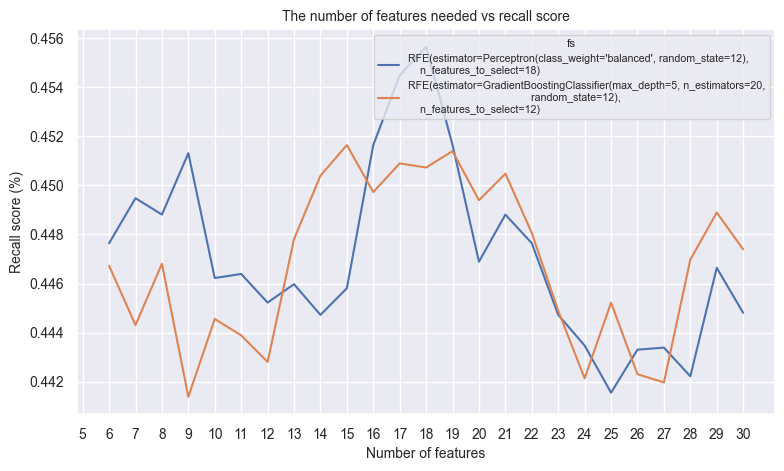

In [77]:
# Find best model to select features and find best number of them
if SEARCH_PARAMS:
    rfe = RFE(estimator=LogisticRegression(class_weight='balanced', max_iter=1000, random_state=12), n_features_to_select=12)

    pipeline_fs = Pipeline(
        steps=[
            ('fs', rfe),
            ('scaler', StandardScaler()),
            ('knc', KNeighborsClassifier())
        ]
    )

    params_fs = [
        # {
        #     "fs": [RFE(estimator=LogisticRegression(class_weight='balanced', max_iter=1000, random_state=12), n_features_to_select=12)],
        #     "fs__n_features_to_select": np.arange(6, X_train_num.shape[1], 1)
        # },
        {
            "fs": [RFE(estimator=Perceptron(class_weight='balanced', random_state=12), n_features_to_select=12)],
            "fs__n_features_to_select": np.arange(6, X_train_num.shape[1], 1)
        },
        # {
        #     "fs": [RFE(estimator=DecisionTreeClassifier(class_weight='balanced', random_state=12), n_features_to_select=12)],
        #     "fs__n_features_to_select": np.arange(6, X_train_num.shape[1], 1)
        # },
        # {
        #     "fs": [RFE(estimator=RandomForestClassifier(class_weight='balanced', random_state=12), n_features_to_select=12)],
        #     "fs__n_features_to_select": np.arange(6, X_train_num.shape[1], 1)
        # },
        {
            "fs": [RFE(estimator=GradientBoostingClassifier(max_depth=5, n_estimators=20, random_state=12), n_features_to_select=12)],
            "fs__n_features_to_select": np.arange(6, X_train_num.shape[1], 1)
        },
    ]
    cv_fs = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
    search_fs = GridSearchCV(pipeline_fs, params_fs, scoring='recall_micro', n_jobs=-1, cv=cv_fs, error_score='raise')
    results_fs = search_fs.fit(X_train_num, y_train)

    print('Best mean accuracy %.3f' % results_fs.best_score_)
    print('Best config feature selection: %s\nBest number of features: %s' % (
        results_fs.best_params_.get('fs'),
        results_fs.best_params_.get('fs__n_features_to_select')
    ))
    y_predict = search_fs.predict(X_test_num)
    score = accuracy_score(y_test, y_predict)
    print(f'\nscore: {score}')

    df_scores_fs = pd.concat([pd.DataFrame(search_fs.cv_results_["params"]),
                        pd.DataFrame(search_fs.cv_results_["mean_test_score"], columns=["recall_score"])], axis=1)
    display(df_scores_fs.sort_values(by='recall_score', ascending=False).head(5))

    plt.figure(figsize=(9,5))
    plt.xlabel('Number of features', fontsize=10)
    plt.xticks(np.arange(4, 31, step=1), fontsize=10)
    plt.ylabel('Recall score (%)', fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('The number of features needed vs recall score', fontsize=10)

    sns.set(font_scale=0.7)
    sns.lineplot(x="fs__n_features_to_select", y="recall_score", hue='fs', data=df_scores_fs.reset_index(level=0))


In [78]:
# https://github.com/TNanukem/paper_implementations/blob/main/PCA.ipynb

# Very low value indicate that using PCA is good option.
def scatter_coefficient(X, normalize=False):
    corr = np.corrcoef(X, rowvar=False)
    if normalize:
        return np.linalg.det(corr) / np.trace(corr)
    else:
        return np.linalg.det(corr)


# Psi index
def psi_index(X, normalize=False):
    corr = np.corrcoef(X, rowvar=False)

    # Eigenvalues and eigenvectors from the correlation matrix
    eig_val, eig_vec = np.linalg.eig(corr)
    idx = eig_val.argsort()[::-1]
    eig_val = eig_val[idx]
    if normalize:
        p = X.shape[0]
        return np.sum((eig_val - 1) ** 2) / (p * (p - 1))
    else:
        return np.sum((eig_val - 1) ** 2)


# Index of matrix
def index_of_matrix(X):
    corr = np.corrcoef(X, rowvar=False)

    # Eigenvalues and eigenvectors from the correlation matrix
    eig_val, eig_vec = np.linalg.eig(corr)
    idx = eig_val.argsort()[::-1]
    eig_val = eig_val[idx]

    return np.sqrt(eig_val[0] / eig_val[-1])


scatter_coefficient = scatter_coefficient(X_num_train_scal)
psi_index = psi_index(X_num_train_scal)
idx_of_matrix = index_of_matrix(X_num_train_scal)

print('Scatter coef: %.19f\nPsi index: %.3f\nIndex of matrix: %.3f' % (scatter_coefficient, psi_index, idx_of_matrix))

Scatter coef: 0.0000000000000000008
Psi index: 104.102
Index of matrix: 33.848


In [43]:
corr = np.corrcoef(X_num_train_scal, rowvar=False)

# Eigenvalues and eigenvectors from the correlation matrix
eig_val, eig_vec = np.linalg.eig(corr)
idx = eig_val.argsort()[::-1]
eig_val = eig_val[idx]
eig_vec = eig_vec[:, idx]

# variance
variance = eig_val / sum(eig_val)

n_comp = 14
print(f'Explained variance by the first {n_comp} components: {sum(variance[:n_comp])}')
feature_vector = eig_vec[:, :n_comp]

Explained variance by the first 14 components: 0.9437412558267776


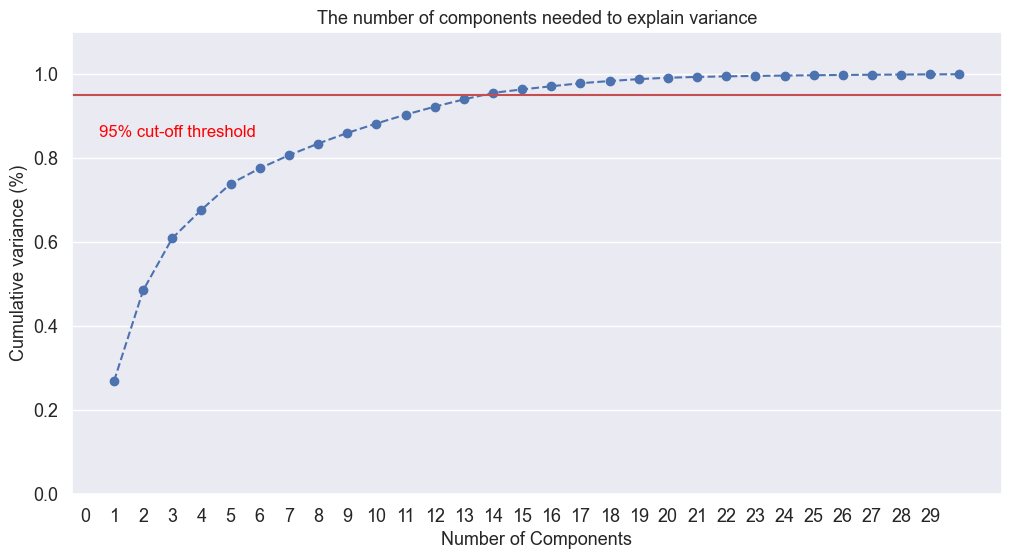

In [230]:
pca = PCA().fit(X_num_train_scal)

plt.rcParams["figure.figsize"] = (12, 6)

fig, ax = plt.subplots()
xi = np.arange(1, 31, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0, 1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components', fontsize=13)
plt.xticks(np.arange(0, 30, step=1), fontsize=13)  #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)', fontsize=13)
plt.yticks(fontsize=13)
plt.title('The number of components needed to explain variance', fontsize=13)

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color='red', fontsize=12)

ax.grid(axis='x')
plt.show()

Best params: {'fs__n_features_to_select': 16, 'pca__n_components': 10}
best score: 0.453

score: 0.45045045045045046


,fs__n_features_to_select,pca__n_components,recall_score
3,16,10,0.453417
19,18,8,0.453217
12,17,10,0.453066
2,16,9,0.453016
11,17,9,0.451514


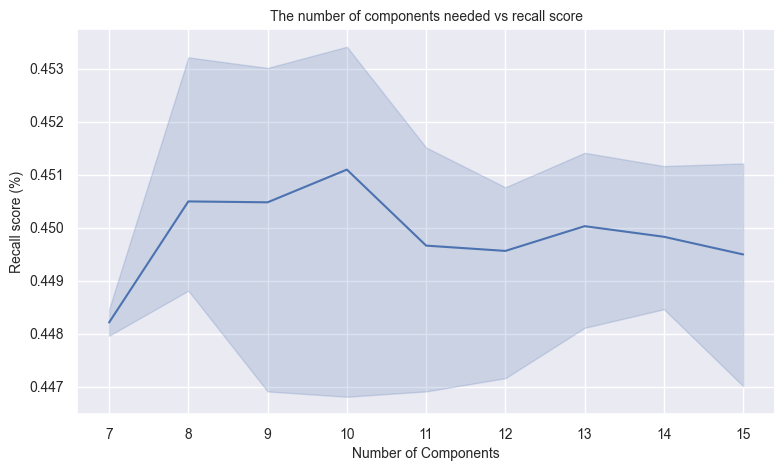

In [84]:
if SEARCH_PARAMS:
    pca = PCA()

    params_pca = dict()
    params_pca['pca__n_components'] = np.arange(7, 16, 1)
    params_pca['fs__n_features_to_select'] = np.arange(16, 19, 1)

    pipeline_pca = Pipeline([
        ('fs', RFE(estimator=GradientBoostingClassifier(max_depth=5, n_estimators=20, random_state=12), n_features_to_select=18)),
        ('scaler', StandardScaler()),
        ('pca', pca),
        ('m', KNeighborsClassifier(n_jobs=-1))])

    search_pca = GridSearchCV(pipeline_pca, params_pca, scoring='recall_micro', cv=cv, n_jobs=-1, error_score='raise')
    results_pca = search_pca.fit(X_train_num, y_train)

    print('Best params: %s\nbest score: %.3f' % (results_pca.best_params_, results_pca.best_score_))

    y_predict = search_pca.predict(X_test_num)
    score = accuracy_score(y_test, y_predict)
    print(f'\nscore: {score}')

    df_pca = pd.concat([pd.DataFrame(search_pca.cv_results_["params"]), pd.DataFrame(search_pca.cv_results_["mean_test_score"], columns=["recall_score"])], axis=1)
    display(df_pca.sort_values(by='recall_score', ascending=False).head(5))

    plt.figure(figsize=(9,5))
    plt.xlabel('Number of Components', fontsize=10)
    plt.xticks(np.arange(6, 30, step=1), fontsize=10)
    plt.ylabel('Recall score (%)', fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('The number of components needed vs recall score', fontsize=10)

    sns.lineplot(x="pca__n_components", y="recall_score", data=df_pca.reset_index(level=0))

Best params: {'classifier': GradientBoostingClassifier(learning_rate=0.2, max_depth=2, n_estimators=10), 'classifier__learning_rate': 0.2, 'classifier__max_depth': 2, 'classifier__n_estimators': 10}
best score: 0.528

score: 0.5435435435435435


,classifier,classifier__class_weight,classifier__max_depth,classifier__n_estimators,classifier__learning_rate,recall_score
54,"GradientBoostingClassifier(learning_rate=0.2, ...",NaN,2,10,0.2,0.528411
36,"GradientBoostingClassifier(learning_rate=0.2, ...",NaN,2,10,0.1,0.526575
37,"GradientBoostingClassifier(learning_rate=0.2, ...",NaN,2,30,0.1,0.526408
72,"GradientBoostingClassifier(learning_rate=0.2, ...",NaN,2,10,0.3,0.522904
38,"GradientBoostingClassifier(learning_rate=0.2, ...",NaN,3,10,0.1,0.521402


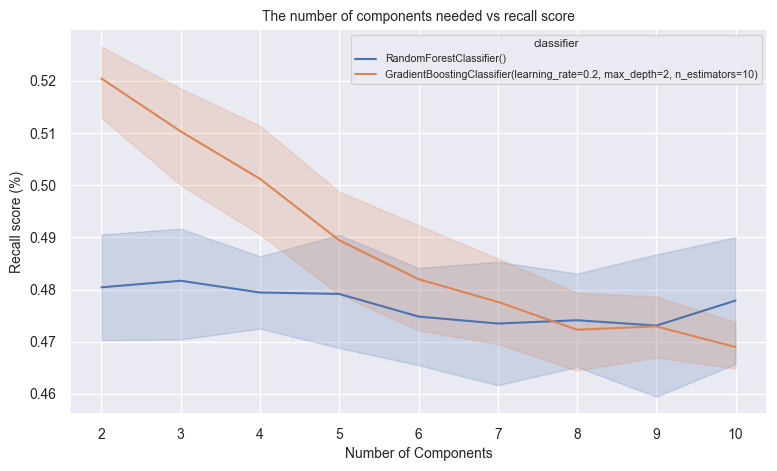

In [88]:
if SEARCH_PARAMS:
    search_model = [
        {
            "classifier": [RandomForestClassifier()],
            "classifier__max_depth": list(range(2, 11)),
            "classifier__n_estimators": [10, 30],
            "classifier__class_weight": ["balanced", "balanced_subsample"],
             # "classifier__max_features": [2, 3, 7, 8, 9, 15]
         },
         {
             "classifier": [GradientBoostingClassifier()],
             "classifier__n_estimators": [10, 30],
             # "classifier__subsample": [0.9, 0.5, 0.2],
             "classifier__learning_rate": [0.1, 0.2, 0.3],
             # "classifier__max_features": [2, 3, 7, 8, 9, 15, 20, 25],
             "classifier__max_depth": list(range(2, 11)),
         }
    ]

    pipeline_model = Pipeline(
        steps=[
            ('outlier_removal', FunctionSampler(func=remove_outlier_IQR, validate=False, kw_args={'low_p': 01., 'high_p': 80.})),
            ('fs', RFE(estimator=GradientBoostingClassifier(), n_features_to_select=16)),
            ('scaler', StandardScaler()),
            ('pca', PCA(10)),
            ('classifier', KNeighborsClassifier())])

    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=43)

    search_model = GridSearchCV(pipeline_model, search_model, cv=cv, n_jobs=-1, verbose=0, error_score='raise')
    results_model = search_model.fit(X_train_num, y_train)
    print('Best params: %s\nbest score: %.3f' % (results_model.best_params_, results_model.best_score_))

    y_predict = results_model.predict(X_test_num)
    score = accuracy_score(y_test, y_predict)
    print(f'\nscore: {score}')

    df_model = pd.concat([pd.DataFrame(results_model.cv_results_["params"]), pd.DataFrame(results_model.cv_results_["mean_test_score"], columns=["recall_score"])], axis=1)
    display(df_model.sort_values(by='recall_score', ascending=False).head(5))

    plt.figure(figsize=(9,5))
    plt.xlabel('Max depth', fontsize=10)
    plt.xticks(np.arange(2, 15, step=1), fontsize=10)
    plt.ylabel('Recall score (%)', fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('The number of components needed vs recall score', fontsize=10)

    sns.lineplot(x="classifier__max_depth", y="recall_score", hue='classifier', data=df_model.reset_index(level=0))

In [104]:
X_cat_train = X_train.select_dtypes(exclude='number')
X_cat_test = X_test.select_dtypes(exclude='number')

df_describe_cat = X_cat_train.describe()
df_describe_cat = df_describe_cat.round(2)
df_describe_cat

,country_name,league_name,season,date,home_team,away_team,lm_winner
count,3995,3995,3995,3995,3995,3995,3995
unique,5,5,4,492,128,128,125
top,England,England Premier League,2010/2011,2011-02-05,Bologna,Manchester City,Draw
freq,1000,1000,1342,28,56,57,997


In [105]:
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    oe.fit(X_train)
    X_train_enc = pd.DataFrame(data=oe.transform(X_train), columns=X_train.columns)
    X_test_enc = pd.DataFrame(data=oe.transform(X_test), columns=X_test.columns)
    return X_train_enc, X_test_enc


def select_categorical_feature(X_train, y_train, X_test, score_func, n='all'):
    fs = SelectKBest(score_func=score_func, k=n)
    fs.fit(X_train, y_train)
    supported_cols = fs.get_support(indices=True)
    X_train_fs = pd.DataFrame(fs.transform(X_train), columns=X_train.iloc[:, supported_cols].columns)
    X_test_fs = pd.DataFrame(fs.transform(X_test), columns=X_train.iloc[:, supported_cols].columns)
    return X_train_fs, X_test_fs, fs

In [106]:
X_cat_train_enc, X_cat_test_enc = prepare_inputs(X_train.select_dtypes(exclude=['number']),
                                                 X_test.select_dtypes(exclude=['number']))
y_train_enc, y_test_enc = prepare_target(y_train, y_test)

print(f'X_train, inputs: {X_cat_train_enc.shape}, target: {y_train_enc.shape}')
print(f'X_train, inputs: {X_cat_test_enc.shape}, target: {y_test_enc.shape}')

X_train, inputs: (3995, 7), target: (3995,)
X_train, inputs: (999, 7), target: (999,)


In [107]:
knn = KNeighborsClassifier()
knn.fit(X_cat_train_enc, y_train_enc)
y_probabilities = knn.predict_proba(X_cat_test_enc)
y_pred = knn.predict(X_cat_test_enc)

score = recall_score(y_test_enc, y_pred, average='micro')
print(f'\nscore: {score}')


score: 0.3983983983983984


Feature 0: country_name False, 0.000000
Feature 1: league_name True, 0.012789
Feature 2: season False, 0.005950
Feature 3: date False, 0.008912
Feature 4: home_team True, 0.047460
Feature 5: away_team True, 0.037221
Feature 6: lm_winner True, 0.018609


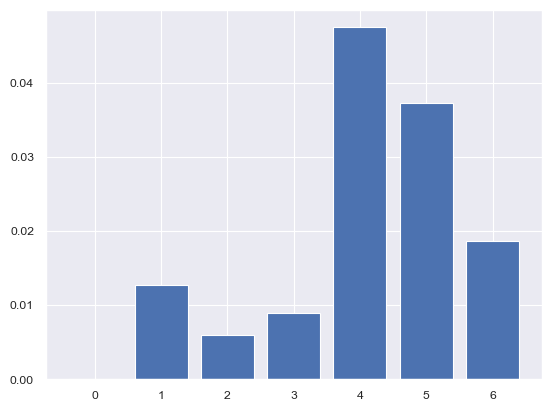

In [111]:
X_cat_train_enc_fs, X_cat_test_enc_fs, fs = select_categorical_feature(X_cat_train_enc, y_train_enc, X_cat_test_enc,
                                                                       mutual_info_classif, n=4)

cols = fs.get_support(indices=True)
features_df_new = X_cat_train_enc.iloc[:, cols]

for i in range(len(fs.scores_)):
    print(f'Feature %d: %s %s, %f' % (i, X_cat_train_enc.iloc[:, i].name, fs.get_support()[i], fs.scores_[i]))

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [112]:
knn = KNeighborsClassifier()
knn.fit(X_cat_train_enc_fs, y_train_enc)
y_probabilities = knn.predict_proba(X_cat_test_enc_fs)
y_pred = knn.predict(X_cat_test_enc_fs)

score = recall_score(y_test_enc, y_pred, average='micro')
print(f'\nscore: {score}')


score: 0.42542542542542544


<Figure size 400x1000 with 0 Axes>

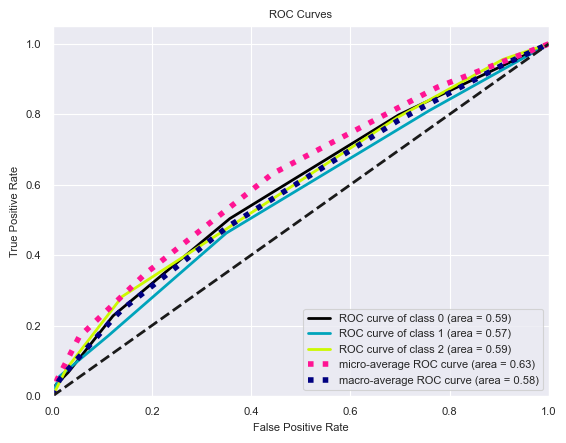

<Figure size 400x1000 with 0 Axes>

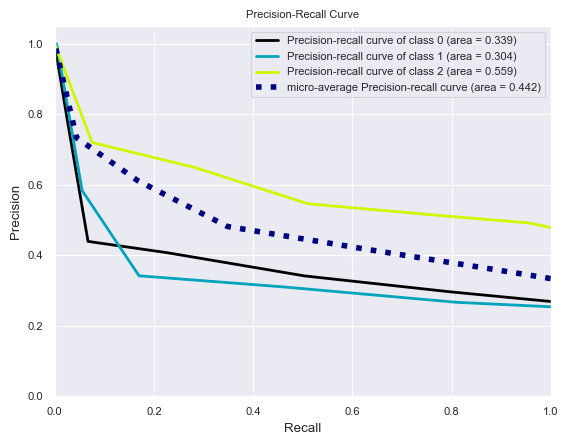

In [113]:
# Plot metrics
plt.figure(figsize=(4, 10))

plot_roc(y_test_enc, y_probabilities, text_fontsize=8, title_fontsize=8)
plt.show()

plt.figure(figsize=(4, 10))
plot_precision_recall(y_test_enc, y_probabilities, text_fontsize=8, title_fontsize=8)
plt.show()

In [50]:
X_train_cat = X_train[['season', 'home_team', 'away_team', 'lm_winner']]
X_test_cat = X_test[['season', 'home_team', 'away_team', 'lm_winner']]

In [51]:
if SEARCH_PARAMS:
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

    grid_cat = [
        {
            "enc": [ce.OrdinalEncoder()],
            "enc__drop_invariant": [True, False],
        },
        {
            "enc": [ce.BackwardDifferenceEncoder()],
            "enc__drop_invariant": [True, False],
        },
        {
            "enc": [ce.BaseNEncoder()],
            "enc__drop_invariant": [True, False],
            "enc__base": [1, 2, 3],
        },
        {
            "enc": [ce.CatBoostEncoder()],
            "enc__drop_invariant": [True, False],
        },
        {
            "enc": [ce.GLMMEncoder()]
        },
        {
            "enc": [ce.JamesSteinEncoder()]
        },
        {
            "enc": [ce.OneHotEncoder()],
            "enc__drop_invariant": [True, False],

        },
    ]

    pipeline_cat = Pipeline(
        steps=[('enc', ce.OrdinalEncoder()),
               ('knc', KNeighborsClassifier())])

    search = GridSearchCV(pipeline_cat, grid_cat, scoring='accuracy', n_jobs=-1, cv=cv, error_score='raise')
    results = search.fit(X_train_cat, y_train)
    print(f'best params: {results.best_params_}')

In [52]:
numeric_features = X_train.select_dtypes(include='number').columns
numeric_transformer = Pipeline(
    steps=[
        ('scaler', Normalizer(norm='l1')),
        ('s', RFE(estimator=LogisticRegression(class_weight='balanced', max_iter=1000, random_state=12), n_features_to_select=25)),
        ('pca', PCA(21)),
    ]
)

categorical_features = X_train[['season', 'home_team', 'away_team', 'lm_winner']].columns
categorical_transformer = ce.BaseNEncoder(base=1, drop_invariant=True)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [53]:
{'classifier': GradientBoostingClassifier(max_depth=18, max_features=1, n_estimators=600,
                            subsample=0.9, learning_rate=0.1),
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 18,
 'classifier__max_features': 2,
 'classifier__n_estimators': 600,
 'classifier__subsample': 0.9}

{'classifier': GradientBoostingClassifier(max_depth=18, max_features=1, n_estimators=600,
                            subsample=0.9),
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 18,
 'classifier__max_features': 2,
 'classifier__n_estimators': 600,
 'classifier__subsample': 0.9}

In [54]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=1)

final_pipeline = Pipeline(
    steps=[
        ('outlier_removal', FunctionSampler(func=remove_outlier_IQR, validate=False, kw_args={'low_p': 01., 'high_p': 75.})),
        ("preprocessor", preprocessor),
        ("classifier", GradientBoostingClassifier(max_depth=18, max_features=1, n_estimators=600, subsample=0.9, learning_rate=0.1))
    ]
)

final_pipeline.fit(X_train, y_train_le)
print("model score: %.3f" % final_pipeline.score(X_test, y_test_le))

model score: 0.498


In [ ]:
# change target to binary
# X_drop['home_winner'] = df_detailed_matches.result_match.apply(lambda x: football_utils.preprocess_category_string(x))
# X_drop['home_winner'].value_counts()

In [ ]:
# min(df_detailed_matches.B365H[0], df_detailed_matches.B365D[0], df_detailed_matches.B365A[0])

In [ ]:
# df_detailed_matches[['B365H', 'B365D', 'B365A']].info()

In [ ]:
# df_detailed_matches.loc[0, ['B365H', 'B365D', 'B365A', 'points_home', 'points_away']]

In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
%reload_ext autoreload
from src.data_processing import points_preprocess_feature

In [67]:
# whether the assumption of bookmakers was correct

points_bookmark_sum = points_preprocess_feature.aggregate_result_match_points(df_detailed_matches, 'points_home', 'points_away')

points_bookmark_sum = points_bookmark_sum.groupby(['type']).sum().loc[:, ['good_points', 'wrong_points']]
points_bookmark_sum.plot(kind='barh', stacked=True, title='All bets added together',
                         xlabel='Correctness of bets by team with higher points.')
plt.show()


KeyboardInterrupt: 

In [ ]:
# whether the assumption of bookmakers was correct

points_bookmark_sum = points_preprocess_feature.aggregate_result_match_points(df_detailed_matches, 'points_home', 'points_away', 'B365H', 'B365D', 'B365A')

points_bookmark_sum = points_bookmark_sum.groupby(['type']).sum().loc[:, ['good_points', 'wrong_points']]
points_bookmark_sum.plot(kind='barh', stacked=True, title='All bets added together',
                         xlabel='Correctness of bets by team with higher points.')
plt.show()

In [ ]:
from sklearn import preprocessing

df_temp = df_detailed_matches.drop(axis=1, columns=['home_team_goal', 'away_team_goal', 'possession'])
encoder = preprocessing.LabelEncoder()
encoder.fit(df_temp['result_match'])
df_temp['result_match'] = encoder.transform(df_temp['result_match'])

In [ ]:
# all_data_plot = sns.pairplot(df_temp)
# all_data_plot.savefig('plot/all_data_plot.png')

In [ ]:
bet_cols_to_plot = ['result_match', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'LBH', 'LBD', 'LBA', 'WHH', 'WHD',
                    'WHA']
goals_cols_to_plot = ['result_match', 'avg_l5m_a', 'avg_l5m_h', 'avg_l5m_aa', 'avg_l5m_hh', 'lm_goals_away',
                      'lm_goals_home', 'streak_la', 'streak_lh', 'streak_wa', 'streak_wh', 'WHA']


In [ ]:
sns.pairplot(df_temp[bet_cols_to_plot])

In [ ]:

# df_drop[['result_match', 'B365H', 'B365A']].groupby('result_match')
# .aggregate({'B365H': ['mean'], 'B365A': ['mean']})
# .reset_index()
# .sort_values(('loss', 'mean'), ascending=False)

In [ ]:
print(f'value counts: \n{df_detailed_matches.result_match.value_counts()}')
sns.countplot(x='result_match', data=df_detailed_matches)
plt.show()


In [ ]:
df_scoring_bet = pd.DataFrame(columns=['bookmaker', 'type', 'good_bet', 'wrong_bet'])

In [ ]:
b365_df = football_utils.aggregate_bookmarks_bets(df_detailed_matches, 'B365H', 'B365D', 'B365A')
bw_df = football_utils.aggregate_bookmarks_bets(df_detailed_matches, 'BWH', 'BWD', 'BWA')
lb_df = football_utils.aggregate_bookmarks_bets(df_detailed_matches, 'LBH', 'LBD', 'LBA')
wh_df = football_utils.aggregate_bookmarks_bets(df_detailed_matches, 'WHH', 'WHD', 'WHA')

In [ ]:
bets_bookmark_res = pd.concat([bw_df, lb_df, b365_df, wh_df])
bets_bookmark_res = bets_bookmark_res.set_index(['bookmaker', 'type'])

In [ ]:
uniques = bets_bookmark_res.index.get_level_values(0).unique()
for i in list(uniques):
    df_single = bets_bookmark_res.loc[i]
    df_single.plot(kind='barh', stacked=True, title=i, xlabel='Correctness of bets')
    plt.show()

In [ ]:
bets_bookmark_sum = bets_bookmark_res.droplevel(0).groupby(['type']).sum().loc[:, ['good_bet', 'wrong_bet']]
bets_bookmark_sum.plot(kind='barh', stacked=True, title='All bets added together', xlabel='Correctness of bets')
plt.show()

In [ ]:
streak_df = df_detailed_matches[['streak_wh', 'streak_wa', 'streak_lh', 'streak_la', 'result_match']]

In [ ]:
streak_df_agg = football_utils.aggregate_streaks(df_detailed_matches, 'streak_wh', 'streak_wa')
streak_df_agg.set_index(keys='type', inplace=True)
streak_df_agg.plot(kind='barh', stacked=True, title='Check if teams with bigger streak wins',
                   xlabel='Correctness streak')
plt.show()

In [ ]:
streak_df_agg_a = football_utils.aggregate_streaks(df_detailed_matches, 'streak_la', 'streak_lh')  #%%
streak_df_agg_a.set_index(keys='type', inplace=True)
streak_df_agg_a.plot(kind='barh', stacked=True, title='Check if teams with bigger streak wins',
                     xlabel='Correctness streak')
plt.show()

In [ ]:
df_detailed_matches['streak_vs_win'] = streak_df[['streak_wh', 'streak_wa']].apply(
    lambda x: football_utils.check_streak_with_win_probability(x, 'streak_wh', 'streak_wa'), axis=1)
# df_drop['streak_vs_win'].plot(kind='barh',stacked=True, title='All bets added together', xlabel='Correctness of bets')

df_detailed_matches['streak_vs_win'].value_counts()

In [ ]:
df_detailed_matches.drop(['streak_vs_win'], axis=1, inplace=True)

In [ ]:
df_detailed_matches.boxplot('last_match_possession_home', 'result_match', rot=30, figsize=(5, 6))
plt.show()
# probably cols to remove, check feature importance
df_detailed_matches['last_match_possession_home'].loc[(df_detailed_matches['last_match_possession_home'] < 80) & (
        df_detailed_matches['last_match_possession_home'] > 20)].X_cat_train()

In [ ]:
df_detailed_matches.select_dtypes(exclude=['number']).nunique()

In [ ]:
df_ = X_drop.drop(['home_winner'], axis=1)
y_ = X_drop['home_winner']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_.drop('result_match', axis=1), df_.result_match, test_size=0.2,
                                                    random_state=333)

In [ ]:
# Transforming non numerical labels into numerical labels
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()

# encoding train labels
encoder.fit(y_train)
y_train_enc = encoder.transform(y_train)

In [ ]:
# Work with both cat and num features, use before encoding on all dataset
from feature_engine.selection import DropConstantFeatures

drop_constant_features = DropConstantFeatures(tol=0.95)
drop_constant_features.fit(X_train)
drop_constant_features.features_to_drop_

In [ ]:
numerical_columns = X_train.select_dtypes(include=['number']).columns

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_t = scaler.fit_transform(X_train[numerical_columns], y_train)
X_test_t = scaler.transform(X_test[numerical_columns])

In [ ]:
from feature_engine.selection import DropCorrelatedFeatures

tr = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.8)
Xt = tr.fit_transform(X_train[numerical_columns])

print(tr.correlated_feature_sets_)

In [ ]:
tr.correlated_feature_sets_

In [ ]:
print(print(Xt.columns))

In [ ]:
N_NEIGHBORS = 10

classifier = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
classifier.fit(Xt, y_train)

# All features
predictions = classifier.predict(X_test[Xt.columns])
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

In [ ]:
N_NEIGHBORS = 10

classifier = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
classifier.fit(X_train[numerical_columns], y_train)

# All features
predictions = classifier.predict(X_test[numerical_columns])
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

In [ ]:
categorical_columns = df_.drop('result_match', axis=1).select_dtypes(exclude=['number']).columns

In [ ]:
# Test chi2
#Testing the relationship
chi_res = chi2_contingency(pd.crosstab(df_drop['result_match'], df_drop['lm_winner']))
print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

property_dummies = pd.get_dummies(data=df_drop[['lm_winner', 'result_match']], columns=['lm_winner'])

chi_res = chi2_contingency(
    pd.crosstab(property_dummies['result_match'], property_dummies['lm_winner_Manchester United']))
print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

In [ ]:
# OHE encoding
data_log = pd.get_dummies(data=df_, columns=df_.select_dtypes(exclude='number').drop('result_match', axis=1).columns,
                          drop_first=True)
data_log['result_match'] = data_log['result_match'].apply(lambda x: 0 if x == 'H' else (1 if x == 'D' else 2))

X_train, X_test, y_train, y_test = train_test_split(data_log.drop('result_match', axis=1), data_log['result_match'],
                                                    test_size=0.2, random_state=333)

N_NEIGHBORS = 8

classifier = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
classifier.fit(X_train, y_train)

In [ ]:
# All features
predictions = classifier.predict(X_test)
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

In [ ]:
OHE_X = football_utils.select_KBest(X_train, y_train, chi2, 20)
OHE_X.shape

In [ ]:
# SelectKBest chi-square, One hot encoding

#Training the model only with the significant features and the numerical features
classifier1 = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
classifier1.fit(OHE_X, y_train)
#Metrics check
predictions = classifier1.predict(X_test[OHE_X.columns])
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

In [ ]:
X_enc = df_.copy()

# prepare input features
oe = OrdinalEncoder()
X_enc[df_.columns] = oe.fit_transform(df_)

# prepare target variable
le = LabelEncoder()
le.fit(y)
y_enc = le.transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=0.2, random_state=333)
OE_X = football_utils.select_KBest(X_train, y_train, chi2, 20)

In [ ]:
# SelectKBest chi-square, Ordinal encoding

#Training the model only with the significant features and the numerical features
classifier2 = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
classifier2.fit(OE_X, y_train)
#Metrics check
predictions = classifier2.predict(X_test[OE_X.columns])
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

In [ ]:
# number of categorical features
print("Number of categorical features : {}".format(len(df_.select_dtypes(include=['object', 'category']).columns)))
print("Number of continuous features : {}".format(len(df_.select_dtypes(include=['number']).columns)))


In [ ]:
# categorical feature selection
sf = football_utils.SelectKBest(chi2, k=30)
sf_fit = sf.fit(X_train, y_train)

# plot the scores
datset = pd.DataFrame()
datset['feature'] = X_train.columns[range(len(sf_fit.scores_))]
datset['scores'] = sf_fit.scores_
datset = datset.sort_values(by='scores', ascending=False)
sns.barplot(datset.iloc[:40]['scores'], datset.iloc[:40]['feature'], color='blue')
sns.set_style('whitegrid')
plt.ylabel('Categorical Feature', fontsize=18)
plt.xlabel('Score', fontsize=18)
plt.show()

In [ ]:
# Decision boundary graph
data = X_train.select_dtypes(include=['number']).loc[:100, ['avg_l5m_h', 'B365H']]


def plot_decision_boundries(X, y, n_neighbors=1):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X, y)

    x_min, x_max = X.iloc[:, 0].min() - 3, X.iloc[:, 0].max() + 3
    y_min, y_max = X.iloc[:, 1].min() - 3, X.iloc[:, 1].max() + 3

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    mesh = np.c_[xx.ravel(), yy.ravel()]
    z = clf.predict(mesh)
    z = z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.pcolormesh(xx, yy, z, cmap='gnuplot', alpha=0.1)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap='gnuplot', edgecolors='r')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f'3-class classification k={n_neighbors}')
    plt.show()


plot_decision_boundries(data, y_train.loc[:100], n_neighbors=N_NEIGHBORS)

In [ ]:
#Creating the ROC-AUC plot, * multiclass format is not supported
preds = classifier.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = {}'.format(round(roc_auc, 2)))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 4))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, predictions),
    display_labels=["class_H", "class_D", "class_A"],
)

cmp.plot(ax=ax)
plt.show();

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=0.2, random_state=333)

model_dataset = KNeighborsClassifier(n_neighbors=N_NEIGHBORS).fit(X_train, y_train)
pred_dataset = model_dataset.predict(X_test)

print(accuracy_score(y_test, pred_dataset))
print(classification_report(y_test, predictions))

In [ ]:
np.unique(y_train)

In [ ]:
np.unique(y_test)

In [ ]:
X_train_enc_ = sf_fit1.X_train_t(X_enc)

X_train_enc_new, X_test_enc_new, y_train_enc_new, y_test_enc_new = train_test_split(X_train_enc_, y_enc, test_size=0.2,
                                                                                    random_state=333)

model_dataset_1 = KNeighborsClassifier(n_neighbors=N_NEIGHBORS).fit(X_train_enc_new, y_train_enc_new)
pred_dataset_1 = model_dataset_1.predict(X_test_enc_new)

print(accuracy_score(y_test_enc_new, pred_dataset_1))
print(classification_report(y_test_enc_new, pred_dataset_1))

In [ ]:
# _ = sns.pairplot(df_drop, vars=df_drop.select_dtypes(include=['number']), hue='result_match')
# plt.savefig('plot/pair_plot.png')

In [ ]:
len(datset.iloc[:5]['scores'])

In [ ]:
df_num = df_drop.select_dtypes(include='number')
df_cat = df_drop.select_dtypes(exclude='number')

In [ ]:
le = preprocessing.LabelEncoder()
X = df_drop
y = le.fit_transform(X.home_winner)

In [ ]:
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

In [ ]:
X = X.drop(['result_match', 'homer_winner'])

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')


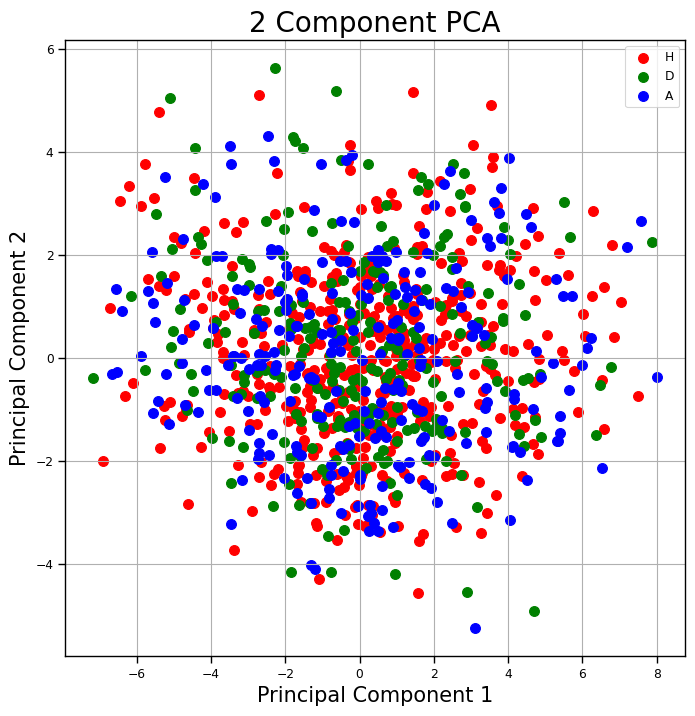

In [99]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)
ax.set_title('2 Component PCA', fontsize=20)

targets = ['H', 'D', 'A']
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['result_match'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal_component_1']
               , finalDf.loc[indicesToKeep, 'principal_component_2']
               , c=color
               , s=50)
ax.legend(targets)
ax.grid()

Text(0, 0.5, 'Proportion of Variance Explained')

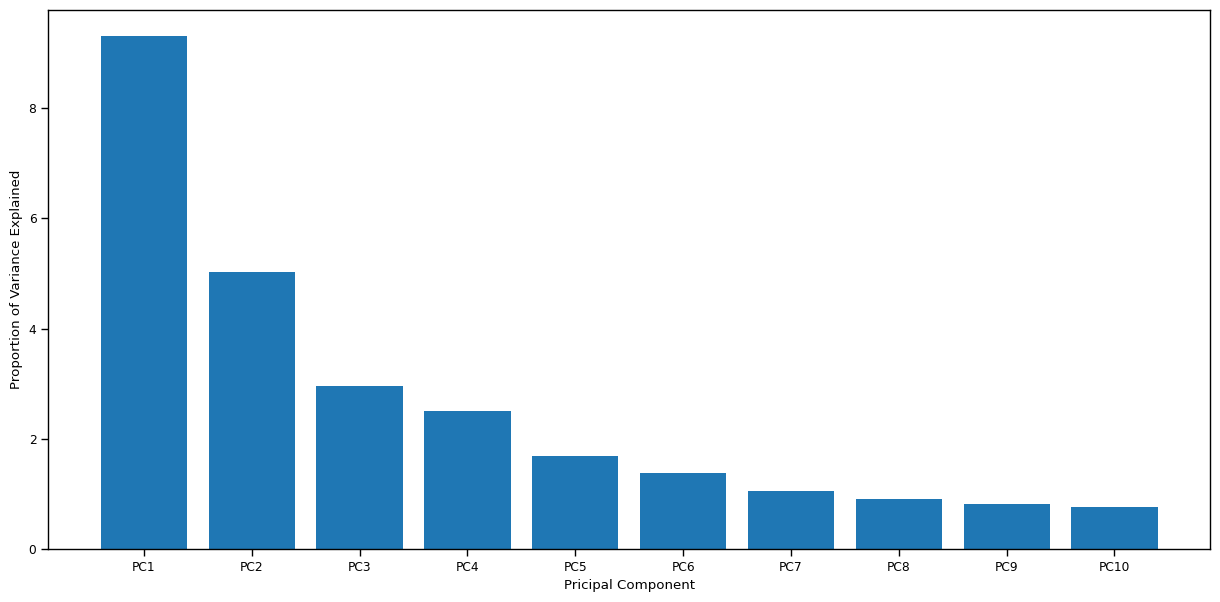

In [28]:
var = pca.explained_variance_[0:10]  #percentage of variance explained
labels = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']

plt.figure(figsize=(15, 7))
plt.bar(labels, var, )
plt.xlabel('Pricipal Component')
plt.ylabel('Proportion of Variance Explained')

In [29]:
df_describe_cat = X_train.select_dtypes(exclude='number').X_cat_train()
df_describe_cat = df_describe_cat.round(2)
df_describe_cat

,country_name,league_name,season,date,home_team,away_team,lm_winner
count,3995,3995,3995,3995,3995,3995,3995
unique,5,5,4,492,127,128,126
top,England,England Premier League,2010/2011,2011-01-15,Aston Villa,RCD Mallorca,Draw
freq,1012,1012,1332,28,55,54,1007


In [64]:
def prepare_inputs(X_train, X_test):
    oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    oe.fit(X_train)
    X_train_enc = pd.DataFrame(data=oe.transform(X_train), columns=X_train.columns)
    X_test_enc = pd.DataFrame(data=oe.transform(X_test), columns=X_test.columns)
    return X_train_enc, X_test_enc


def prepare_target(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_test_enc


def select_categorical_feature(X_train, y_train, X_test, score_func, n='all'):
    fs = SelectKBest(score_func=score_func, k=n)
    fs.fit(X_train, y_train)
    supported_cols = fs.get_support(indices=True)
    X_train_fs = pd.DataFrame(fs.transform(X_train), columns=X_train.iloc[:, supported_cols].columns)
    X_test_fs = pd.DataFrame(fs.transform(X_test), columns=X_train.iloc[:, supported_cols].columns)
    return X_train_fs, X_test_fs, fs

In [65]:
X_cat_train_enc, X_cat_test_enc = prepare_inputs(X_train.select_dtypes(exclude=['number']),
                                                 X_test.select_dtypes(exclude=['number']))
y_train_enc, y_test_enc = prepare_target(y_train, y_test)

print(f'X_train, inputs: {X_cat_train_enc.shape}, target: {y_train_enc.shape}')
print(f'X_train, inputs: {X_cat_test_enc.shape}, target: {y_test_enc.shape}')

X_train, inputs: (3995, 7), target: (3995,)
X_train, inputs: (999, 7), target: (999,)


Feature 0: country_name False, 0.000000
Feature 1: league_name False, 0.016498
Feature 2: season False, 0.017564
Feature 3: date False, 0.001312
Feature 4: home_team True, 0.048683
Feature 5: away_team True, 0.035153
Feature 6: lm_winner True, 0.018737


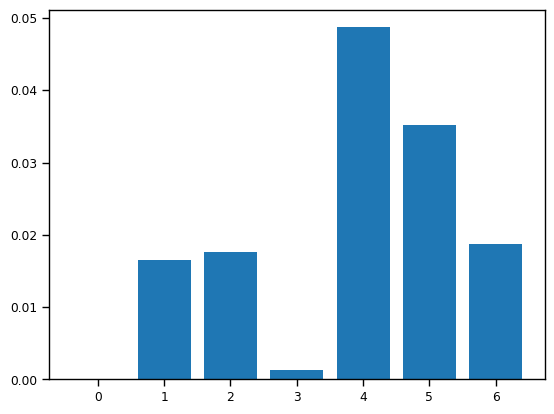

In [73]:
X_cat_train_enc_fs, X_cat_test_enc_fs, fs = select_categorical_feature(X_cat_train_enc, y_train_enc, X_cat_test_enc,
                                                                       mutual_info_classif, n=3)

cols = fs.get_support(indices=True)
features_df_new = X_cat_train_enc.iloc[:, cols]

for i in range(len(fs.scores_)):
    print(f'Feature %d: %s %s, %f' % (i, X_cat_train_enc.iloc[:, i].name, fs.get_support()[i], fs.scores_[i]))

plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

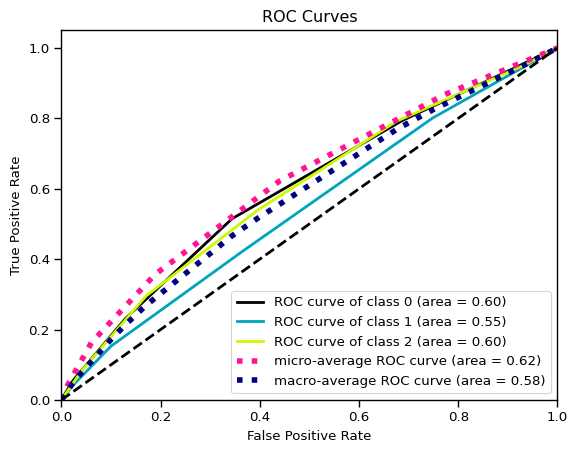

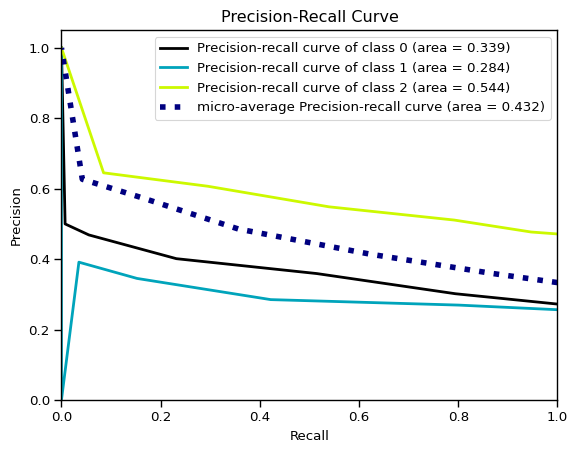

In [74]:
# model
model = KNeighborsClassifier()
model.fit(X_cat_train_enc_fs, y_train_enc)
y_probabilities = model.predict_proba(X_cat_test_enc_fs)
y_pred = model.predict(X_cat_test_enc_fs)
# Plot metrics
plot_roc(y_test_enc, y_probabilities)
plt.show()

plot_precision_recall(y_test_enc, y_probabilities)
plt.show()

In [75]:
score = accuracy_score(y_test_enc, y_pred)
print(f'score: {score}')

score: 0.4394394394394394


In [46]:
# Balancing data
count = y_train.value_counts()
count.plot.bar()
plt.xlabel('Target class.')
plt.ylabel('Number of samples.')
plt.show()

In [ ]:
n_samples = count.median().astype(np.int64)


def sample_strategy(X, y, n_samples, t='majority'):
    target_classes = ''
    if t == 'majority':
        target_classes = y.value_counts() > n_samples
    elif t == 'minority':
        target_classes = y.value_counts() < n_samples
    tc_idx = target_classes[target_classes == True].index
    # target_classes_all=target_classes.value_counts().index
    sample_strategy = {}
    for target in tc_idx:
        sample_strategy[target] = n_samples
    return sample_strategy

In [47]:
from imblearn.under_sampling import ClusterCentroids

under_sampler = ClusterCentroids(sampling_strategy=sample_strategy(X_train, y_train, n_samples, t='majority'))

X_under = under_sampler.fit_resample(X_train, y_train)

ValueError: could not convert string to float: 'Spain'

In [22]:
# change target to binary
# X_drop['home_winner'] = df_detailed_matches.result_match.apply(lambda x: football_utils.preprocess_category_string(x))
# X_drop['home_winner'].value_counts()

no     2604
yes    2390
Name: home_winner, dtype: int64

In [23]:
sns.set_style('darkgrid')

In [ ]:
points_bookmark_sum = points_preprocess_feature.aggregate_result_match_points(df_detailed_matches, 'points_home',
                                                                              'points_away')

points_bookmark_sum = points_bookmark_sum.groupby(['type']).sum().loc[:, ['good_points', 'wrong_points']]
points_bookmark_sum.plot(kind='barh', stacked=True, title='All bets added together',
                         xlabel='Correctness of bets by team with higher points.')
plt.show()


In [24]:
from sklearn import preprocessing

df_temp = df_detailed_matches.drop(axis=1, columns=['home_team_goal', 'away_team_goal', 'possession'])
encoder = preprocessing.LabelEncoder()
encoder.fit(df_temp['result_match'])
df_temp['result_match'] = encoder.transform(df_temp['result_match'])

In [25]:
# all_data_plot = sns.pairplot(df_temp)
# all_data_plot.savefig('plot/all_data_plot.png')

In [26]:
bet_cols_to_plot = ['result_match', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'LBH', 'LBD', 'LBA', 'WHH', 'WHD',
                    'WHA']
goals_cols_to_plot = ['result_match', 'avg_l5m_a', 'avg_l5m_h', 'avg_l5m_aa', 'avg_l5m_hh', 'lm_goals_away',
                      'lm_goals_home', 'streak_la', 'streak_lh', 'streak_wa', 'streak_wh', 'WHA']


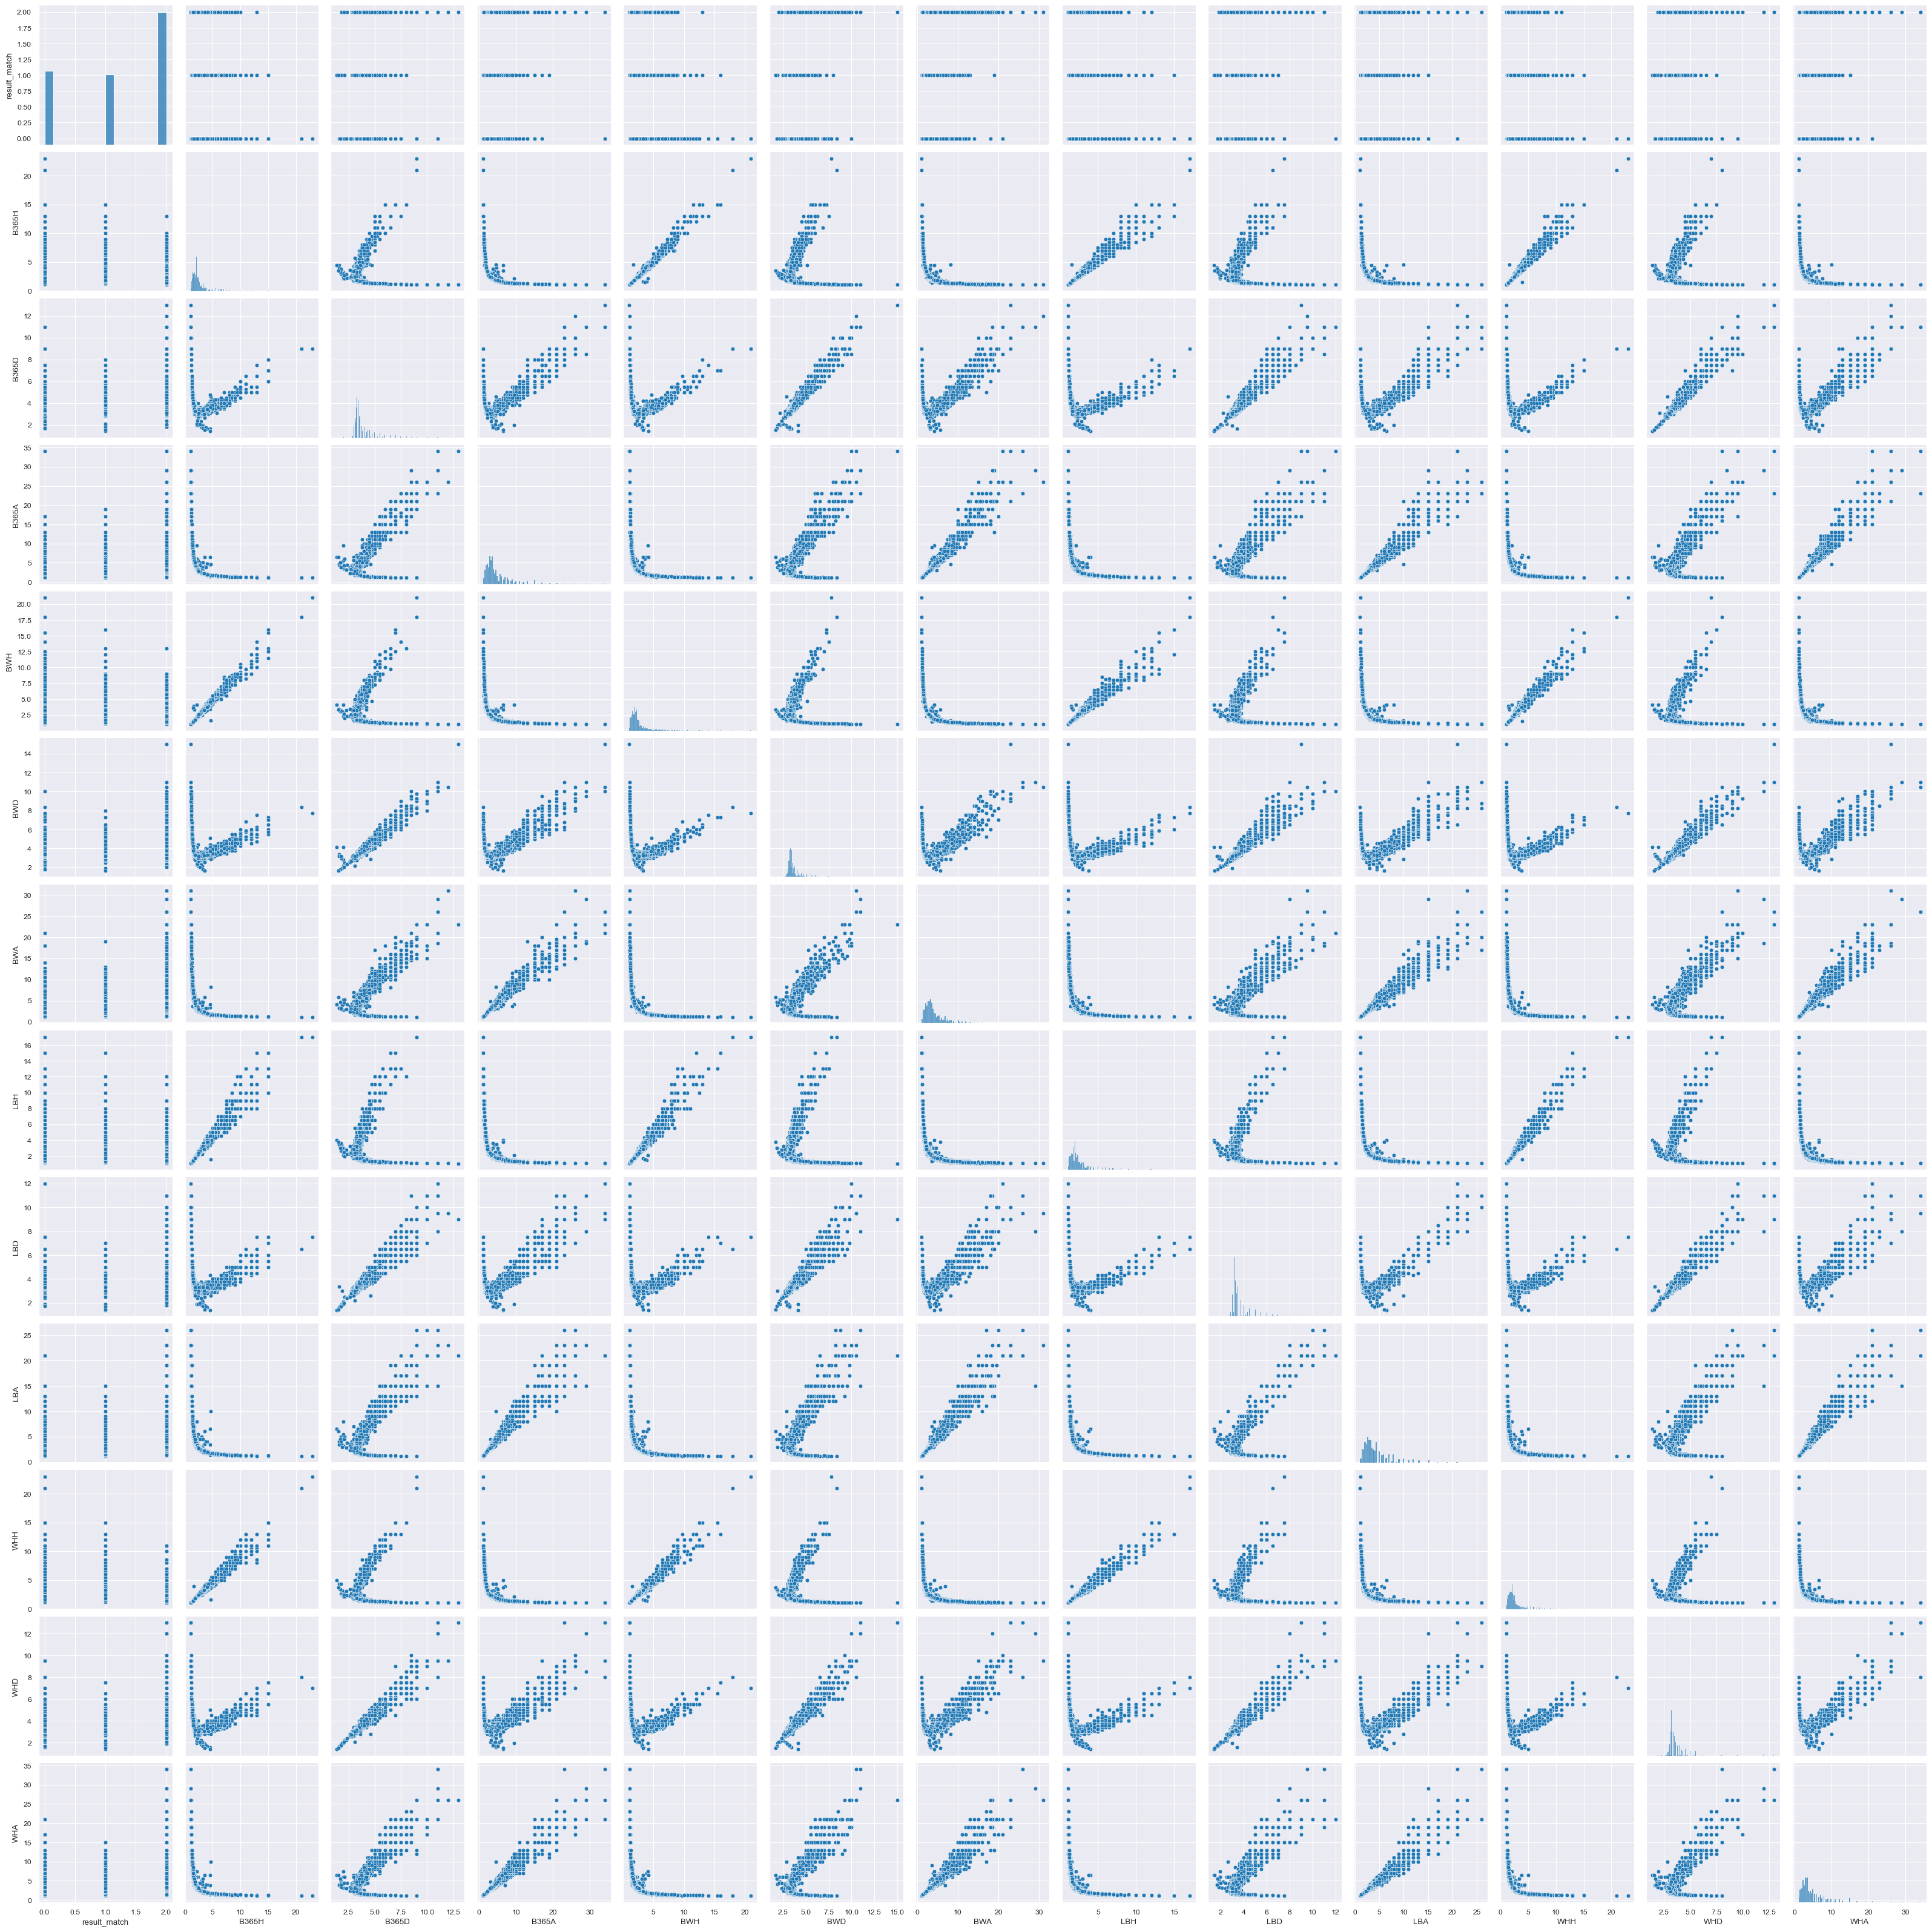

In [27]:
sns.pairplot(df_temp[bet_cols_to_plot])

In [28]:

# df_drop[['result_match', 'B365H', 'B365A']].groupby('result_match')
# .aggregate({'B365H': ['mean'], 'B365A': ['mean']})
# .reset_index()
# .sort_values(('loss', 'mean'), ascending=False)

value counts: 
H    2390
A    1338
D    1266
Name: result_match, dtype: int64


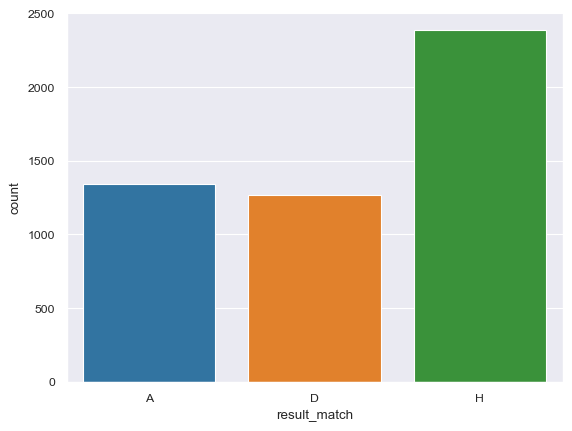

In [29]:
print(f'value counts: \n{df_detailed_matches.result_match.value_counts()}')
sns.countplot(x='result_match', data=df_detailed_matches)
plt.show()


In [30]:
df_scoring_bet = pd.DataFrame(columns=['bookmaker', 'type', 'good_bet', 'wrong_bet'])

In [31]:
b365_df = football_utils.aggregate_bookmarks_bets(df_detailed_matches, 'B365H', 'B365D', 'B365A')
bw_df = football_utils.aggregate_bookmarks_bets(df_detailed_matches, 'BWH', 'BWD', 'BWA')
lb_df = football_utils.aggregate_bookmarks_bets(df_detailed_matches, 'LBH', 'LBD', 'LBA')
wh_df = football_utils.aggregate_bookmarks_bets(df_detailed_matches, 'WHH', 'WHD', 'WHA')

In [32]:
bets_bookmark_res = pd.concat([bw_df, lb_df, b365_df, wh_df])
bets_bookmark_res = bets_bookmark_res.set_index(['bookmaker', 'type'])

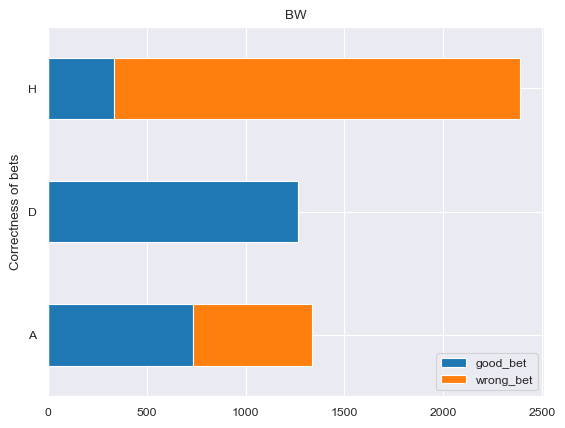

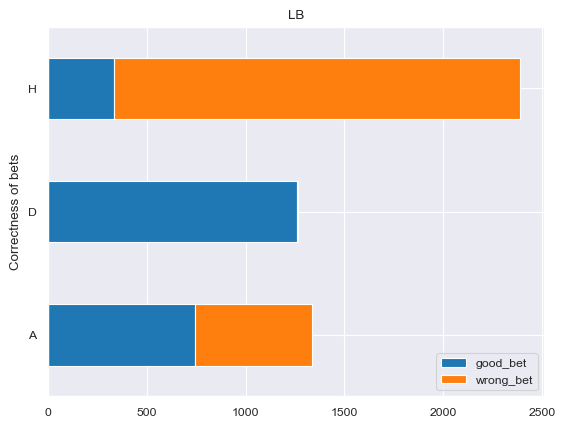

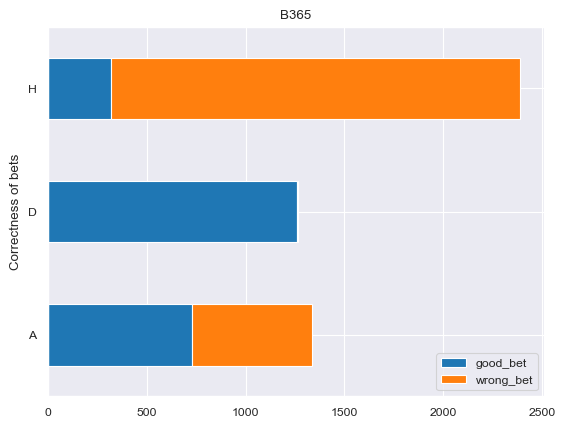

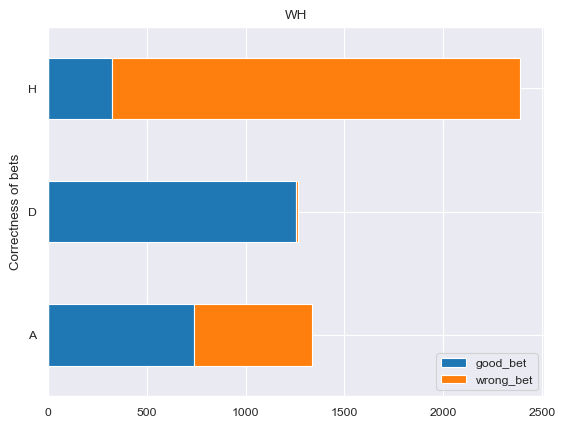

In [33]:
uniques = bets_bookmark_res.index.get_level_values(0).unique()
for i in list(uniques):
    df_single = bets_bookmark_res.loc[i]
    df_single.plot(kind='barh', stacked=True, title=i, xlabel='Correctness of bets')
    plt.show()

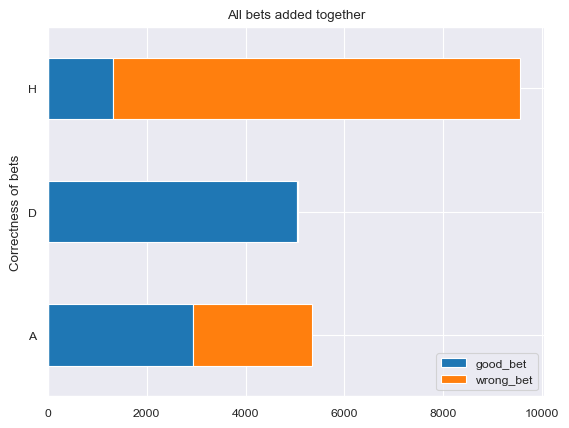

In [34]:
bets_bookmark_sum = bets_bookmark_res.droplevel(0).groupby(['type']).sum().loc[:, ['good_bet', 'wrong_bet']]
bets_bookmark_sum.plot(kind='barh', stacked=True, title='All bets added together', xlabel='Correctness of bets')
plt.show()

In [35]:
streak_df = df_detailed_matches[['streak_wh', 'streak_wa', 'streak_lh', 'streak_la', 'result_match']]

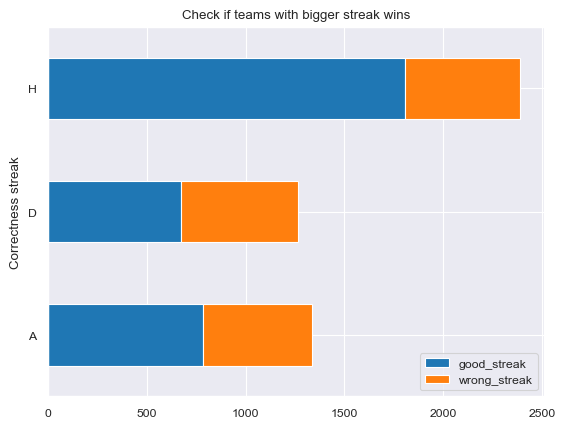

In [36]:
streak_df_agg = football_utils.aggregate_streaks(df_detailed_matches, 'streak_wh', 'streak_wa')
streak_df_agg.set_index(keys='type', inplace=True)
streak_df_agg.plot(kind='barh', stacked=True, title='Check if teams with bigger streak wins',
                   xlabel='Correctness streak')
plt.show()

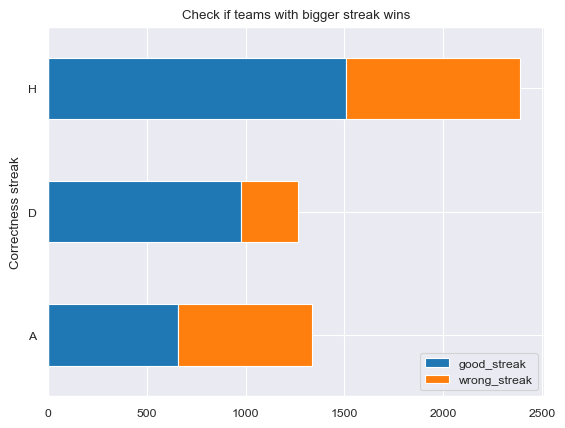

In [37]:
streak_df_agg_a = football_utils.aggregate_streaks(df_detailed_matches, 'streak_la', 'streak_lh')  #%%
streak_df_agg_a.set_index(keys='type', inplace=True)
streak_df_agg_a.plot(kind='barh', stacked=True, title='Check if teams with bigger streak wins',
                     xlabel='Correctness streak')
plt.show()

In [38]:
df_detailed_matches['streak_vs_win'] = streak_df[['streak_wh', 'streak_wa']].apply(
    lambda x: football_utils.check_streak_with_win_probability(x, 'streak_wh', 'streak_wa'), axis=1)
# df_drop['streak_vs_win'].plot(kind='barh',stacked=True, title='All bets added together', xlabel='Correctness of bets')

df_detailed_matches['streak_vs_win'].value_counts()

False    4994
Name: streak_vs_win, dtype: int64

In [39]:
df_detailed_matches.drop(['streak_vs_win'], axis=1, inplace=True)

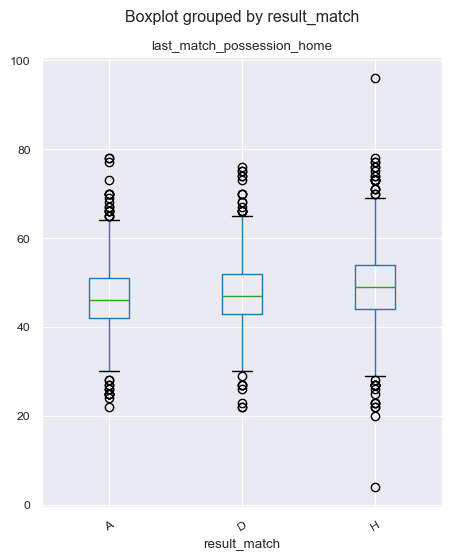

count    4991.000000
mean       48.156482
std         7.645985
min        22.000000
25%        44.000000
50%        48.000000
75%        53.000000
max        78.000000
Name: last_match_possession_home, dtype: float64

In [40]:
df_detailed_matches.boxplot('last_match_possession_home', 'result_match', rot=30, figsize=(5, 6))
plt.show()
# probably cols to remove, check feature importance
df_detailed_matches['last_match_possession_home'].loc[(df_detailed_matches['last_match_possession_home'] < 80) & (
        df_detailed_matches['last_match_possession_home'] > 20)].X_cat_train()

In [41]:
df_detailed_matches.select_dtypes(exclude=['number']).nunique()

country_name       5
league_name        5
season             4
date             526
home_team        128
away_team        128
possession      2971
result_match       3
lm_winner        127
dtype: int64

In [ ]:
df_ = X_drop.drop(['home_winner'], axis=1)
y_ = X_drop['home_winner']

In [76]:
X_train, X_test, y_train, y_test = train_test_split(df_.drop('result_match', axis=1), df_.result_match, test_size=0.2,
                                                    random_state=333)

In [83]:
# Transforming non numerical labels into numerical labels
from sklearn import preprocessing

encoder = preprocessing.LabelEncoder()

# encoding train labels
encoder.fit(y_train)
y_train_enc = encoder.transform(y_train)

In [77]:
# Work with both cat and num features, use before encoding on all dataset
from feature_engine.selection import DropConstantFeatures

drop_constant_features = DropConstantFeatures(tol=0.95)
drop_constant_features.fit(X_train)
drop_constant_features.features_to_drop_

[]

In [86]:
numerical_columns = X_train.select_dtypes(include=['number']).columns

In [87]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_t = scaler.fit_transform(X_train[numerical_columns], y_train)
X_test_t = scaler.transform(X_test[numerical_columns])

In [125]:
from feature_engine.selection import DropCorrelatedFeatures

tr = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.8)
Xt = tr.fit_transform(X_train[numerical_columns])

print(tr.correlated_feature_sets_)

[{'points_home', 'points_away', 'stage'}, {'WHH', 'LBH', 'BWH', 'B365H'}, {'WHD', 'WHA', 'LBD', 'BWA', 'BWD', 'B365D', 'B365A', 'LBA'}]


In [126]:
tr.correlated_feature_sets_

[{'points_away', 'points_home', 'stage'},
 {'B365H', 'BWH', 'LBH', 'WHH'},
 {'B365A', 'B365D', 'BWA', 'BWD', 'LBA', 'LBD', 'WHA', 'WHD'}]

In [127]:
print(print(Xt.columns))

Index(['stage', 'B365H', 'B365D', 'lm_goals_away', 'lm_goals_home',
       'avg_l5m_hh', 'avg_l5m_h', 'avg_l5m_aa', 'avg_l5m_a', 'streak_last_wh',
       'streak_last_wa', 'streak_last_lh', 'streak_last_la',
       'last_match_possession_away', 'last_match_possession_home',
       'days_since_lma', 'days_since_lmh', 'avg_points_l5m_h',
       'avg_points_l5m_a', 'date_year', 'date_month', 'date_day'],
      dtype='object')
None


In [137]:
N_NEIGHBORS = 10

classifier = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
classifier.fit(Xt, y_train)

# All features
predictions = classifier.predict(X_test[Xt.columns])
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

0.44789579158316634
              precision    recall  f1-score   support

           A       0.37      0.29      0.32       271
           D       0.26      0.21      0.23       243
           H       0.54      0.66      0.59       484

    accuracy                           0.45       998
   macro avg       0.39      0.38      0.38       998
weighted avg       0.42      0.45      0.43       998



In [138]:
N_NEIGHBORS = 10

classifier = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
classifier.fit(X_train[numerical_columns], y_train)

# All features
predictions = classifier.predict(X_test[numerical_columns])
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

0.4498997995991984
              precision    recall  f1-score   support

           A       0.41      0.35      0.38       271
           D       0.23      0.18      0.20       243
           H       0.54      0.64      0.58       484

    accuracy                           0.45       998
   macro avg       0.39      0.39      0.39       998
weighted avg       0.43      0.45      0.43       998



In [63]:
categorical_columns = df_.drop('result_match', axis=1).select_dtypes(exclude=['number']).columns

In [64]:
# Test chi2
#Testing the relationship
chi_res = chi2_contingency(pd.crosstab(df_drop['result_match'], df_drop['lm_winner']))
print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

property_dummies = pd.get_dummies(data=df_drop[['lm_winner', 'result_match']], columns=['lm_winner'])

chi_res = chi2_contingency(
    pd.crosstab(property_dummies['result_match'], property_dummies['lm_winner_Manchester United']))
print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 257.6162202703757, p-value: 0.35682662614984645
Chi2 Statistic: 3.4735710841091434, p-value: 0.17608551133907518


In [65]:
# OHE encoding
data_log = pd.get_dummies(data=df_, columns=df_.select_dtypes(exclude='number').drop('result_match', axis=1).columns,
                          drop_first=True)
data_log['result_match'] = data_log['result_match'].apply(lambda x: 0 if x == 'H' else (1 if x == 'D' else 2))

X_train, X_test, y_train, y_test = train_test_split(data_log.drop('result_match', axis=1), data_log['result_match'],
                                                    test_size=0.2, random_state=333)

N_NEIGHBORS = 8

classifier = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8)

In [66]:
# All features
predictions = classifier.predict(X_test)
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

0.48296593186372744
              precision    recall  f1-score   support

           0       0.54      0.76      0.63       484
           1       0.27      0.18      0.22       243
           2       0.47      0.25      0.33       271

    accuracy                           0.48       998
   macro avg       0.42      0.40      0.39       998
weighted avg       0.45      0.48      0.45       998



In [67]:
OHE_X = football_utils.select_KBest(X_train, y_train, chi2, 20)
OHE_X.shape

(3989, 20)

In [68]:
# SelectKBest chi-square, One hot encoding

#Training the model only with the significant features and the numerical features
classifier1 = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
classifier1.fit(OHE_X, y_train)
#Metrics check
predictions = classifier1.predict(X_test[OHE_X.columns])
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

0.5130260521042084
              precision    recall  f1-score   support

           0       0.56      0.76      0.65       484
           1       0.36      0.25      0.29       243
           2       0.47      0.30      0.37       271

    accuracy                           0.51       998
   macro avg       0.46      0.44      0.44       998
weighted avg       0.49      0.51      0.49       998



In [69]:
X_enc = df_.copy()

# prepare input features
oe = OrdinalEncoder()
X_enc[df_.columns] = oe.fit_transform(df_)

# prepare target variable
le = LabelEncoder()
le.fit(y)
y_enc = le.transform(y)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=0.2, random_state=333)
OE_X = football_utils.select_KBest(X_train, y_train, chi2, 20)

In [71]:
# SelectKBest chi-square, Ordinal encoding

#Training the model only with the significant features and the numerical features
classifier2 = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)
classifier2.fit(OE_X, y_train)
#Metrics check
predictions = classifier2.predict(X_test[OE_X.columns])
print(accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

0.467935871743487
              precision    recall  f1-score   support

           0       0.40      0.46      0.43       271
           1       0.23      0.16      0.19       243
           2       0.58      0.63      0.60       484

    accuracy                           0.47       998
   macro avg       0.41      0.42      0.41       998
weighted avg       0.45      0.47      0.46       998



In [68]:
# number of categorical features
print("Number of categorical features : {}".format(len(df_.select_dtypes(include=['object', 'category']).columns)))
print("Number of continuous features : {}".format(len(df_.select_dtypes(include=['number']).columns)))


Number of categorical features : 7
Number of continuous features : 34


c:\users\kamil\documents\eu_soccer_ml\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


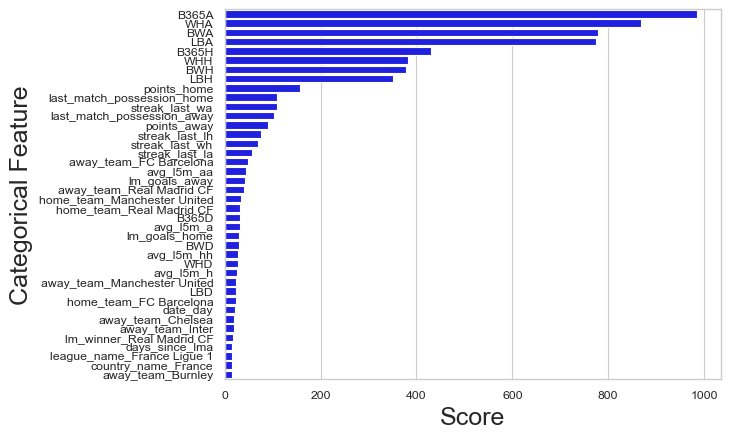

In [104]:
# categorical feature selection
sf = football_utils.SelectKBest(chi2, k=30)
sf_fit = sf.fit(X_train, y_train)

# plot the scores
datset = pd.DataFrame()
datset['feature'] = X_train.columns[range(len(sf_fit.scores_))]
datset['scores'] = sf_fit.scores_
datset = datset.sort_values(by='scores', ascending=False)
sns.barplot(datset.iloc[:40]['scores'], datset.iloc[:40]['feature'], color='blue')
sns.set_style('whitegrid')
plt.ylabel('Categorical Feature', fontsize=18)
plt.xlabel('Score', fontsize=18)
plt.show()

In [ ]:
# Decision boundary graph
data = X_train.select_dtypes(include=['number']).loc[:100, ['avg_l5m_h', 'B365H']]


def plot_decision_boundries(X, y, n_neighbors=1):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X, y)

    x_min, x_max = X.iloc[:, 0].min() - 3, X.iloc[:, 0].max() + 3
    y_min, y_max = X.iloc[:, 1].min() - 3, X.iloc[:, 1].max() + 3

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    mesh = np.c_[xx.ravel(), yy.ravel()]
    z = clf.predict(mesh)
    z = z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.pcolormesh(xx, yy, z, cmap='gnuplot', alpha=0.1)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap='gnuplot', edgecolors='r')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f'3-class classification k={n_neighbors}')
    plt.show()


plot_decision_boundries(data, y_train.loc[:100], n_neighbors=N_NEIGHBORS)

In [ ]:
#Creating the ROC-AUC plot, * multiclass format is not supported
preds = classifier.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = {}'.format(round(roc_auc, 2)))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 4))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, predictions),
    display_labels=["class_H", "class_D", "class_A"],
)

cmp.plot(ax=ax)
plt.show();

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=0.2, random_state=333)

model_dataset = KNeighborsClassifier(n_neighbors=N_NEIGHBORS).fit(X_train, y_train)
pred_dataset = model_dataset.predict(X_test)

print(accuracy_score(y_test, pred_dataset))
print(classification_report(y_test, predictions))

0.46993987975951906
              precision    recall  f1-score   support

           0       0.23      0.59      0.34       271
           1       0.27      0.18      0.22       243
           2       0.26      0.08      0.12       484

    accuracy                           0.24       998
   macro avg       0.25      0.28      0.22       998
weighted avg       0.25      0.24      0.20       998



In [147]:
np.unique(y_train)

array([0, 1, 2])

In [148]:
np.unique(y_test)

array([0, 1, 2])

In [149]:
X_train_enc_ = sf_fit1.X_train_t(X_enc)

X_train_enc_new, X_test_enc_new, y_train_enc_new, y_test_enc_new = train_test_split(X_train_enc_, y_enc, test_size=0.2,
                                                                                    random_state=333)

model_dataset_1 = KNeighborsClassifier(n_neighbors=N_NEIGHBORS).fit(X_train_enc_new, y_train_enc_new)
pred_dataset_1 = model_dataset_1.predict(X_test_enc_new)

print(accuracy_score(y_test_enc_new, pred_dataset_1))
print(classification_report(y_test_enc_new, pred_dataset_1))

0.4909819639278557
              precision    recall  f1-score   support

           0       0.44      0.49      0.46       271
           1       0.29      0.19      0.23       243
           2       0.58      0.64      0.61       484

    accuracy                           0.49       998
   macro avg       0.44      0.44      0.44       998
weighted avg       0.47      0.49      0.48       998



In [ ]:
# _ = sns.pairplot(df_drop, vars=df_drop.select_dtypes(include=['number']), hue='result_match')
# plt.savefig('plot/pair_plot.png')

In [122]:
len(datset.iloc[:5]['scores'])

5

In [ ]:
df_num = df_drop.select_dtypes(include='number')
df_cat = df_drop.select_dtypes(exclude='number')

In [ ]:
le = preprocessing.LabelEncoder()
X = df_drop
y = le.fit_transform(X.home_winner)

In [ ]:
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

In [ ]:
X = X.drop(['result_match', 'homer_winner'])

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
